In [1]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats,special
from copy import deepcopy
from math import pi
import os
import time
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import concurrent.futures
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LassoCV

import asgl

from lifelines import KaplanMeierFitter
import random as r
import inspect
import warnings
warnings.filterwarnings('ignore')

C:\Users\omar9\anaconda3\envs\suavizador\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
lecturas=pd.read_csv("results.csv")
lecturas["index_col"]=lecturas.index
lecturas

,medidor,fecha,kW_del,kVAr_del,kW_rec,kVAr_rec,tension,falla,Causa_Id,index_col
0,Trf Miraflores T1,2017-01-01 00:00:00,9028.498047,993.392395,0.0,0.000000,12166.338867,0,2401,0
1,Trf Miraflores T1,2017-01-01 00:15:00,8570.544922,936.934265,0.0,0.000000,12191.869141,0,2401,1
2,Trf Miraflores T1,2017-01-01 00:30:00,8488.869141,875.079468,0.0,0.000000,12209.926758,0,2401,2
3,Trf Miraflores T1,2017-01-01 00:45:00,8687.238281,881.507874,0.0,0.000000,12198.285156,0,2401,3
4,Trf Miraflores T1,2017-01-01 01:00:00,8843.103516,930.686401,0.0,0.000000,12193.687500,0,2401,4
...,...,...,...,...,...,...,...,...,...,...
154672,Trf Miraflores T1,2021-04-30 23:00:00,8532.578125,0.000000,0.0,558.630371,NaN,0,2401,154672
154673,Trf Miraflores T1,2021-04-30 23:15:00,8303.352539,0.000000,0.0,563.043518,NaN,0,2401,154673
154674,Trf Miraflores T1,2021-04-30 23:30:00,7994.871582,0.000000,0.0,586.591919,NaN,0,2401,154674
154675,Trf Miraflores T1,2021-04-30 23:45:00,7681.770020,0.000000,0.0,663.821289,NaN,0,2401,154675


In [3]:
lecturas["fecha"]=pd.to_datetime(lecturas["fecha"])

### aqui elimino los duplicados
lecturas=lecturas.drop_duplicates(subset=["fecha"],ignore_index=True)
lecturas["index_col"]=lecturas.index

In [4]:
#si falla = 1, me retorna las duraciones de los errores y sus inicios
#si falla = 0, me retorna los tiempos de vida y sus inicios
#si antes = 1, la tabla incluirá valores antes del error, los cuales tendrán un tiempo hacia atrás dado por delta * periodos 
#si antes = 0, no hará lo anterior
def buscaerrores(data,delta=pd.to_timedelta("00:15:00"),falla=0, antes=0, periodos=3, aguante=4):
    if not type(data["fecha"])==pd.core.series.Series:
        data["fecha"]=pd.to_datetime(data["fecha"])
    datos=data[data["falla"]==falla]
    valores_final=[]
    valores=[]
    valores_antes=[]
    verificador=0 #se usa solo para el primer elemento
    contador=1
    demoras=[] #se guardan las duraciones de los errores en minutos
    ndemoras=0
    for i in range(len(datos)):
        if verificador==0 :
            valores.append(datos.iloc[i]["index_col"])
            pivotvalores=datos.iloc[i]["index_col"]
            pivot=datos.iloc[i]["fecha"]
            verificador=1
            ndemoras+=1
        else:
            fechita=datos.iloc[i]["fecha"]
            if pivot+contador*delta==fechita:
                contador+=1
                ndemoras+=1
            else:
                indice_i_menos1=datos["index_col"].iloc[i-1] #ultimo 0 del tiempo de vida (anterior)
                indice_i=datos["index_col"].iloc[i] #inicio del tiempo de vida
                #con este if me aseguro de que no sea un salto donde faltan datos
                if len(data.iloc[indice_i_menos1:indice_i][data["falla"]==1].index)>0:
                    if datos.iloc[i]["fecha"] - datos.iloc[i-1]["fecha"] >= aguante *delta :
                        valores.append(datos.iloc[i]["index_col"])
                        demoras.append(ndemoras)
                        valores_final.append(indice_i_menos1)
                        if antes != 0 and indice_i - indice_i_menos1 >= periodos:
                            valores_antes.append(data.iloc[indice_i_menos1 - periodos]["index_col"])
                        else:
                            valores_antes.append(valores[len(valores)-2]) #agrego el inicio del tiempo de vida anterior
                    else:
                        continue
                    pivot=datos.iloc[i]["fecha"]
                    ndemoras=0
                    contador=1
                else:#tengo q sumar a los contadores lo que me salté
                    continue
    
    #aqui guardo la duracion del ultimo error, se agrega si es que el último inicio de error no es el último error
    if pivot != datos.iloc[len(datos)-1]["fecha"]:
        demoras.append(ndemoras)
        valores_final.append(datos.iloc[i]["index_col"])
        if antes != 0 and indice_i - indice_i_menos1 >= periodos:
            valores_antes.append(data.iloc[indice_i_menos1 - periodos]["index_col"])
        else:
            valores_antes.append(valores[len(valores)-2])
    #else: #tengo que convertir el delta a minutos
        #continue

    
    newdata=data.iloc[valores]
    
    demoras=np.array(demoras)*15
    newdata["demoras (min)"]=demoras
    
    #aquí agrego los elementos del final de la falla
    newdatafinal=data.iloc[valores_final]  
    newdata["kW_del-finaltv"]=np.array(newdatafinal["kW_del"])
    newdata["kVAr_del-finaltv"]=np.array(newdatafinal["kVAr_del"])
    #newdata["kW_rec-finaltv"]=np.array(newdatafinal["kW_rec"])
    newdata["kVAr_rec-finaltv"]=np.array(newdatafinal["kVAr_rec"])
    #newdata["tension-finaltv"]=np.array(newdatafinal["tension"])
    newdata["index_col-finaltv"]=np.array(newdatafinal["index_col"])
    #newdata["falla-finaltv"]=np.array(newdatafinal["falla"])
    
    newdata=newdata.drop(["falla"],axis=1)
                   
    if antes!=0:
        newdataantes=data.iloc[valores_antes]  
        newdata["kW_del-"+str(periodos)]=np.array(newdataantes["kW_del"])
        newdata["kVAr_del-"+str(periodos)]=np.array(newdataantes["kVAr_del"])
        #newdata["kW_rec-"+str(periodos)]=np.array(newdataantes["kW_rec"])
        newdata["kVAr_rec-"+str(periodos)]=np.array(newdataantes["kVAr_rec"])
        #newdata["tension-"+str(periodos)]=np.array(newdataantes["tension"])
        newdata["index_col-"+str(periodos)]=np.array(newdataantes["index_col"])
        #newdata["falla-"+str(periodos)]=np.array(newdataantes["falla"])
        
    return (demoras,newdata)

In [5]:
periodos=5 #luego uso este valor
duracionesvida, iniciostv = buscaerrores(lecturas, falla=0, aguante=0, antes=0, periodos=periodos)

In [10]:
#iniciostv.drop(["kW_rec","kVAr_rec","Causa_Id","index_col","kW_del-finaltv","kVAr_del-finaltv","kVAr_rec-finaltv","index_col-finaltv"],axis=1)

In [9]:
iniciostv

,medidor,fecha,kW_del,kVAr_del,kW_rec,kVAr_rec,tension,Causa_Id,index_col,demoras (min),kW_del-finaltv,kVAr_del-finaltv,kVAr_rec-finaltv,index_col-finaltv
0,Trf Miraflores T1,2017-01-01 00:00:00,9028.498047,993.392395,0.0,0.000000,12166.338867,2401,0,870,7781.748535,1019.381165,0.000000,57
67,Trf Miraflores T1,2017-01-01 16:45:00,6968.071289,1009.682861,0.0,0.000000,12031.390625,2401,67,2865,7507.607422,506.889374,0.000000,258
291,Trf Miraflores T1,2017-01-04 00:45:00,7772.124023,543.603516,0.0,0.000000,12187.063477,2401,291,510,6383.367676,302.394257,9.169328,325
420,Trf Miraflores T1,2017-01-05 09:00:00,6433.287109,403.414154,0.0,0.000000,12068.129883,2401,420,2070,7345.292480,793.724731,0.000000,558
572,Trf Miraflores T1,2017-01-06 23:00:00,9546.424805,679.756775,0.0,0.000000,12139.771484,2401,572,3645,7747.388184,519.919312,0.000000,815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151361,Trf Miraflores T1,2021-04-26 20:15:00,11102.785156,0.000000,0.0,889.027954,NaN,2401,151361,990,8426.861328,0.000000,805.333618,151427
151432,Trf Miraflores T1,2021-04-27 14:00:00,9193.463867,0.000000,0.0,562.062500,NaN,2401,151432,285,10870.709961,0.000000,524.183411,151451
151458,Trf Miraflores T1,2021-04-27 20:30:00,11183.133789,0.000000,0.0,664.653748,NaN,2401,151458,390,5026.400391,0.000000,658.388245,151484
151499,Trf Miraflores T1,2021-04-28 06:45:00,5117.940430,0.000000,0.0,795.973267,NaN,2401,151499,780,11456.409180,0.000000,611.067688,151551


In [7]:
iniciostv["log(demoras)"]=np.log(iniciostv["demoras (min)"])

In [8]:
#0 -> max/prom
#1 -> max-min
#2 -> x_f-x_i
columnas={"kW_del":[[0],[0],[0]],"kVAr_del":[[0],[0],[0]],"kVAr_rec":[[0],[0],[0]]}
for i in range(1,len(iniciostv)):
    indice_i_menos1=iniciostv["index_col"].iloc[i-1]
    indice_i=iniciostv["index_col"].iloc[i]
    maximos=lecturas.iloc[indice_i_menos1:indice_i].max()
    minimos=lecturas.iloc[indice_i_menos1:indice_i].min()
    promedios=lecturas.iloc[indice_i_menos1:indice_i].mean()
    for name,lista in columnas.items():
        lista[0].append(promedios[name]/maximos[name]) #aquí agrego max/prom
        lista[1].append(maximos[name]-minimos[name]) #aquí agrego max-min
        lista[2].append(iniciostv[name+"-finaltv"].iloc[i]-iniciostv[name].iloc[i]) #aquí agrego x_f-x_i

nombrescolumnas=[" max/prom"," max-min"," x_f-x_i"]
for name,lista in columnas.items():
    for i in range(len(nombrescolumnas)):
        iniciostv[name+nombrescolumnas[i]]=lista[i]

In [9]:
#Aquí agrego los columnas con valores al final del tiempo de vida
#0 -> pendiente
#1 -> prom
#2 -> max-min
columnas={"kW_del":[[0],[0],[0]],"kVAr_del":[[0],[0],[0]],"kVAr_rec":[[0],[0],[0]]}
for i in range(1,len(iniciostv)):
    indice_i_menos_delta=iniciostv["index_col-finaltv"].iloc[i]-periodos
    indice_i=iniciostv["index_col-finaltv"].iloc[i]
    maximos=lecturas.iloc[indice_i_menos_delta:indice_i].max()
    minimos=lecturas.iloc[indice_i_menos_delta:indice_i].min()
    promedios=lecturas.iloc[indice_i_menos_delta:indice_i].mean()
    for name,lista in columnas.items():
        lista[0].append((iniciostv.iloc[i][name+"-finaltv"]-iniciostv.iloc[i][name+"-"+str(periodos)])/periodos*15) #aquí agrego pendiente
        lista[1].append(promedios[name]) #aquí agrego prom
        lista[2].append(maximos[name]-minimos[name]) #aquí agrego max-min

nombrescolumnas=[" pendiente delta"," prom delta"," max-min delta"]
for name,lista in columnas.items():
    for i in range(len(nombrescolumnas)):
        iniciostv[name+nombrescolumnas[i]]=lista[i]

In [10]:
covariables_a_utilizar=['kW_del', 'kVAr_del', 'kVAr_rec',
       'kW_del-finaltv','kVAr_del-finaltv', 'kVAr_rec-finaltv',
       'kW_del-'+str(periodos),'kVAr_del-'+str(periodos), 'kVAr_rec-'+str(periodos), 'kW_del max/prom', 
       'kW_del max-min', 'kW_del x_f-x_i',
       'kVAr_del max/prom', 'kVAr_del max-min', 'kVAr_del x_f-x_i',
       'kVAr_rec max/prom', 'kVAr_rec max-min', 'kVAr_rec x_f-x_i',
       'kW_del pendiente delta', 'kW_del prom delta', 'kW_del max-min delta',
       'kVAr_del pendiente delta', 'kVAr_del prom delta',
       'kVAr_del max-min delta', 'kVAr_rec pendiente delta',
       'kVAr_rec prom delta', 'kVAr_rec max-min delta' ]

In [11]:
iniciostv1=iniciostv[covariables_a_utilizar]

In [12]:
########### gráficos y tablas de correlaciones

In [13]:
iniciostv1_corr=iniciostv1.corr(method="pearson")
iniciostv1_corr

,kW_del,kVAr_del,kVAr_rec,kW_del-finaltv,kVAr_del-finaltv,kVAr_rec-finaltv,kW_del-5,kVAr_del-5,kVAr_rec-5,kW_del max/prom,...,kVAr_rec x_f-x_i,kW_del pendiente delta,kW_del prom delta,kW_del max-min delta,kVAr_del pendiente delta,kVAr_del prom delta,kVAr_del max-min delta,kVAr_rec pendiente delta,kVAr_rec prom delta,kVAr_rec max-min delta
kW_del,1.000000,0.048522,-0.044106,0.717102,0.001494,0.015609,0.749201,-0.002834,0.045741,0.171020,...,0.082260,-0.002105,0.724705,0.217027,0.008213,-0.008745,0.151808,-0.064951,0.033915,0.208660
kVAr_del,0.048522,1.000000,-0.503548,0.019024,0.723804,-0.420821,0.030766,0.769886,-0.426768,-0.043689,...,0.116222,-0.026897,0.023068,-0.017351,-0.093743,0.742732,0.323083,0.024686,-0.426090,-0.332795
kVAr_rec,-0.044106,-0.503548,1.000000,-0.015765,-0.412385,0.736050,-0.015599,-0.416470,0.759521,-0.017783,...,-0.367717,-0.001799,-0.013642,0.028879,0.008267,-0.413822,-0.344348,-0.071154,0.750177,0.349628
kW_del-finaltv,0.717102,0.019024,-0.015765,1.000000,0.079657,-0.061266,0.918531,0.056885,-0.030780,0.073322,...,-0.062426,0.301718,0.972999,0.425098,0.046066,0.063475,0.245432,-0.063524,-0.045536,0.104977
kVAr_del-finaltv,0.001494,0.723804,-0.412385,0.079657,1.000000,-0.506830,0.075000,0.878581,-0.496360,-0.057559,...,-0.127638,0.018996,0.079651,-0.003883,0.246485,0.952976,0.421289,-0.008018,-0.521164,-0.443454
kVAr_rec-finaltv,0.015609,-0.420821,0.736050,-0.061266,-0.506830,1.000000,-0.063585,-0.470480,0.889530,-0.002064,...,0.358842,-0.000598,-0.062214,0.033057,-0.073922,-0.494677,-0.423428,0.208095,0.953112,0.470738
kW_del-5,0.749201,0.030766,-0.015599,0.918531,0.075000,-0.063585,1.000000,0.097884,-0.069257,0.075691,...,-0.065841,-0.099743,0.959494,0.229809,-0.046522,0.081345,0.233759,0.013949,-0.067634,0.078454
kVAr_del-5,-0.002834,0.769886,-0.416470,0.056885,0.878581,-0.470480,0.097884,1.000000,-0.507853,-0.067913,...,-0.072067,-0.093290,0.079342,-0.044045,-0.246067,0.944975,0.420280,0.093376,-0.496074,-0.442138
kVAr_rec-5,0.045741,-0.426768,0.759521,-0.030780,-0.496360,0.889530,-0.069257,-0.507853,1.000000,0.008737,...,0.174719,0.089816,-0.050789,0.082087,0.023212,-0.501710,-0.429408,-0.261768,0.956060,0.487621
kW_del max/prom,0.171020,-0.043689,-0.017783,0.073322,-0.057559,-0.002064,0.075691,-0.067913,0.008737,1.000000,...,0.021396,0.003593,0.079588,0.020645,0.025752,-0.066843,0.019184,-0.022732,0.001529,0.030350


In [14]:
#clúster jerárquico

In [15]:
iniciostv1.replace([np.nan,np.inf, -np.inf], 0, inplace=True)
iniciostv.replace([np.nan,np.inf, -np.inf], 0, inplace=True)

X, y = iniciostv1, iniciostv["log(demoras)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

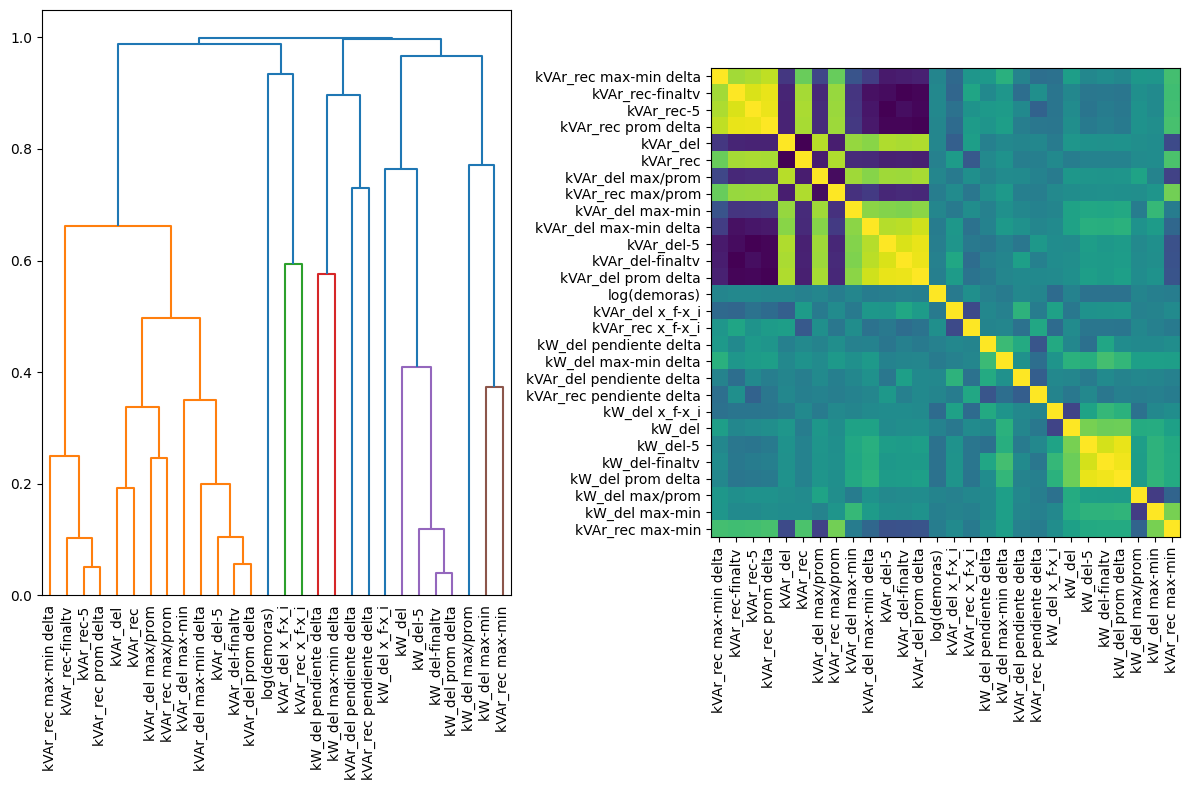

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
X["log(demoras)"]=iniciostv["log(demoras)"]
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.complete(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=iniciostv1.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [17]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.3, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [18]:
#Aqui hago la lista de las columnas que utilizaré, escogiendo el elemento de cada cluster que más se relacione con log(demoras)
#SI UTILIZARÉ ESTO
columnas=iniciostv1.columns.to_list()
num=len(iniciostv1.columns.to_list())
val=columnas.index("log(demoras)")

covariables_a_utilizar=[]

for cluster in cluster_id_to_feature_ids.values():
    valor=0 #cambiar a 1 si hay que elegir las que tengan menor correlación
    indice=0
    if val not in cluster: 
        for col in cluster:
            if distance_matrix[col,val]>valor: #cambiar esta condicion segun lo q diga el profe
                valor=distance_matrix[col,val]
                indice=col
        covariables_a_utilizar.append(columnas[indice])
covariables_a_utilizar

['kW_del',
 'kVAr_rec',
 'kW_del-5',
 'kVAr_del-finaltv',
 'kVAr_rec max-min delta',
 'kW_del max/prom',
 'kW_del max-min',
 'kW_del x_f-x_i',
 'kVAr_del max/prom',
 'kVAr_del max-min',
 'kVAr_del x_f-x_i',
 'kVAr_rec max-min',
 'kVAr_rec x_f-x_i',
 'kW_del pendiente delta',
 'kW_del max-min delta',
 'kVAr_del pendiente delta',
 'kVAr_rec pendiente delta']

In [19]:
iniciostv2=iniciostv[covariables_a_utilizar]

In [20]:
iniciostv2["log(demoras)"]=iniciostv["log(demoras)"]

In [21]:
iniciostv2_corr=iniciostv2.corr(method="pearson")
iniciostv2_corr

,kW_del,kVAr_rec,kW_del-5,kVAr_del-finaltv,kVAr_rec max-min delta,kW_del max/prom,kW_del max-min,kW_del x_f-x_i,kVAr_del max/prom,kVAr_del max-min,kVAr_del x_f-x_i,kVAr_rec max-min,kVAr_rec x_f-x_i,kW_del pendiente delta,kW_del max-min delta,kVAr_del pendiente delta,kVAr_rec pendiente delta,log(demoras)
kW_del,1.000000,-0.044106,0.749201,0.001494,0.208660,0.570718,0.385098,-0.395586,0.088359,0.197229,-0.064123,0.234176,0.082260,-0.002105,0.217027,0.008213,-0.064951,-0.022956
kVAr_rec,-0.044106,1.000000,-0.015599,-0.412385,0.349628,0.122006,0.036064,0.038082,-0.557182,-0.483078,0.138058,0.395492,-0.367717,-0.001799,0.028879,0.008267,-0.071154,-0.011157
kW_del-5,0.749201,-0.015599,1.000000,0.075000,0.078454,0.522050,0.409337,0.205915,0.044582,0.220413,0.057693,0.299466,-0.065841,-0.099743,0.229809,-0.046522,0.013949,-0.128920
kVAr_del-finaltv,0.001494,-0.412385,0.075000,1.000000,-0.443454,0.088207,0.034405,0.103641,0.624288,0.427961,0.342322,-0.339505,-0.127638,0.018996,-0.003883,0.246485,-0.008018,0.019005
kVAr_rec max-min delta,0.208660,0.349628,0.078454,-0.443454,1.000000,0.151512,0.125332,-0.141732,-0.350148,-0.247219,-0.135709,0.329076,0.164589,0.075286,0.266646,-0.002731,-0.049514,0.024018
kW_del max/prom,0.570718,0.122006,0.522050,0.088207,0.151512,1.000000,-0.077114,-0.077440,0.292885,0.035946,-0.014576,-0.019282,0.013804,0.058764,0.169563,0.024685,-0.029303,0.004236
kW_del max-min,0.385098,0.036064,0.409337,0.034405,0.125332,-0.077114,1.000000,0.024143,-0.156036,0.368291,0.016607,0.610304,-0.008033,0.047270,0.155153,-0.006828,-0.016096,-0.012193
kW_del x_f-x_i,-0.395586,0.038082,0.205915,0.103641,-0.141732,-0.077440,0.024143,1.000000,-0.072757,0.000685,0.191224,0.094242,-0.192558,0.400279,0.268828,0.049670,0.003414,-0.134347
kVAr_del max/prom,0.088359,-0.557182,0.044582,0.624288,-0.350148,0.292885,-0.156036,-0.072757,1.000000,0.459650,-0.116589,-0.581103,0.065361,-0.019159,-0.022347,-0.006949,0.010209,0.045582
kVAr_del max-min,0.197229,-0.483078,0.220413,0.427961,-0.247219,0.035946,0.368291,0.000685,0.459650,1.000000,-0.128997,-0.043319,0.057044,-0.024094,0.009404,-0.048755,0.001309,0.037941


<AxesSubplot: >

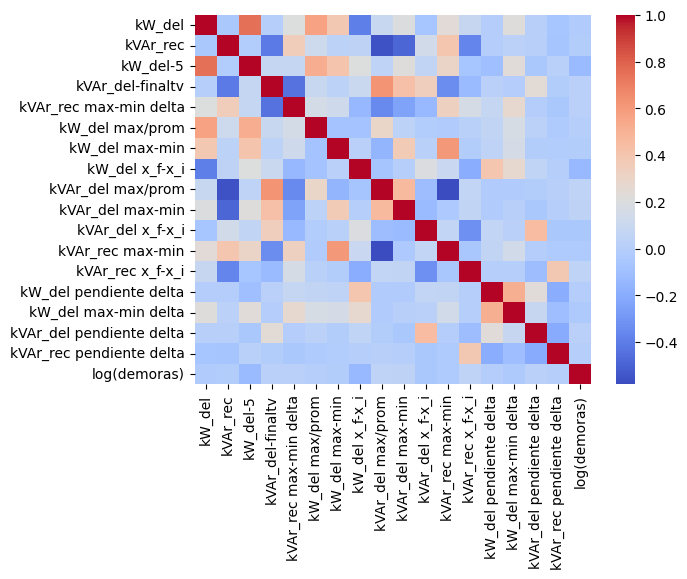

In [22]:
sns.heatmap(iniciostv2_corr,xticklabels=iniciostv2_corr.columns,yticklabels=iniciostv2_corr.columns,cmap="coolwarm")

In [23]:
#Regresión Lasso

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html

In [24]:
X=iniciostv.get(covariables_a_utilizar).values
X=np.nan_to_num(X, posinf=0, neginf=0)

Y=iniciostv["log(demoras)"].values
Y = np.nan_to_num(Y,posinf=0,neginf=0)

In [25]:
desviaciones=np.array([i.std() for i in X.T])

In [26]:
start_time=time.time()
lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(X, y)
fit_time=time.time()-start_time

In [27]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [28]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X/desviaciones, Y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

In [29]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
0.217940,6496.835831,6496.835831
0.206853,6495.679867,6501.122359
0.084067,6457.981146,6468.866131
0.061887,6453.183502,6469.510980
0.040831,6446.010365,6467.780336
0.038724,6447.126382,6474.338845
0.038025,6448.730259,6481.385216
0.029108,6446.041430,6484.138879
0.026129,6446.706124,6490.246066


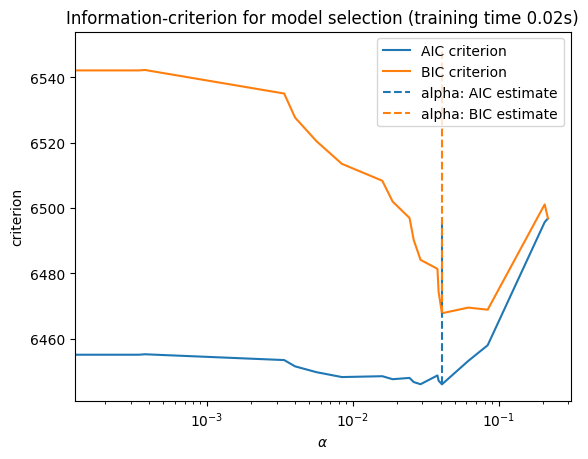

In [30]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

In [31]:
alpha_bic

0.040831370298799616

In [32]:
lasso=Lasso(alpha=alpha_bic+0.00005)
lasso.fit(X/desviaciones,Y)
coeficientes_lasso=lasso.coef_

In [33]:
coeficientes_lasso

array([ 0.        ,  0.        , -0.17649995,  0.        ,  0.        ,
        0.0454191 ,  0.        , -0.13723682,  0.        ,  0.05803058,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [34]:
a=dict(zip(covariables_a_utilizar,coeficientes_lasso))
covariables_a_utilizar=[c for c,d in a.items() if d!=0]

In [35]:
#primero entrega el intercepto, luego los coeficientes de x y al final el gamma
def miniregresionlineal(X,Y,logx=0,logy=0,from0=False):
    if type(X)==list: 
        dimX=len(X)
    else:
        dimX=1
    
    X=np.array(X)
    Y=np.array(Y)
    if logx==1:
        X=np.log(X)
    if logy==1:
        Y=np.log(Y)
    
    if dimX==1:
        X1 = np.nan_to_num(X,posinf=0, neginf=0).reshape(X.size)
    else:
        X1 = np.nan_to_num(X,posinf=0, neginf=0)
    Y=np.array(Y).reshape(Y.size)
    Y=np.nan_to_num(Y,posinf=0, neginf=0)
    
    if dimX==1:
        datos=pd.DataFrame({"Y":Y, "X":X1})
        X = datos[['X']]
        Y = datos['Y']
    else:
        tamaño=X[0].size
        comandopd="pd.DataFrame({'Y':Y,"
        for i in range(len(X)):
            if i<len(X)-1:
                comandopd+="'X"+str(i+1)+"':np.array(X["+str(i)+"]).reshape(tamaño),"
            else:
                comandopd+="'X"+str(i+1)+"':np.array(X["+str(i)+"]).reshape(tamaño)})"
        #print(comandopd)
        datos=eval(comandopd)
        Y = datos['Y']
        X=np.array(datos[['X1']])
        for i in range(2,dimX+1):
            X=np.append(X,eval("np.array(datos[['X"+str(i)+"']])"),axis=1)
            #X=X.T
        X = np.nan_to_num(X,posinf=0, neginf=0)
    
    modelo = LinearRegression(fit_intercept = from0)
    modelo.fit(X = X, y = Y )
    b0gorro = modelo.intercept_
    if dimX==1:
        b1=modelo.coef_.flatten()[0]
    else:
        b1=modelo.coef_
    
    if dimX==1:
        return (b0gorro,b1)
    else:
        coefs=[x for x in b1]
        valores=[b0gorro]+coefs
        return valores 
    

def regresionlineal(X,Y,logx=0,logy=0,from0=False):
    if type(X)==list: 
        dimX=len(X)
    else:
        dimX=1
    
    X=np.array(X)
    Y=np.array(Y)
    Y2=deepcopy(Y)
    if logx==1:
        X=np.log(X)
    if logy==1:
        Y=np.log(Y)

    Y1 = np.nan_to_num(Y,posinf=0, neginf=0).reshape(Y.size)
    if dimX==1:
        X1 = np.nan_to_num(X,posinf=0, neginf=0).reshape(X.size)
    else:
        X1 = np.nan_to_num(X,posinf=0, neginf=0)
    
    if dimX==1:
        datos1=pd.DataFrame({"Y":Y1, "X":X1})
        X = datos1[['X']]
        y = datos1['Y']
    else:
        tamaño=X[0].size
        comandopd="pd.DataFrame({'Y':Y1,"
        for i in range(len(X)):
            if i<len(X)-1:
                comandopd+="'X"+str(i+1)+"':np.array(X["+str(i)+"]).reshape(tamaño),"
            else:
                comandopd+="'X"+str(i+1)+"':np.array(X["+str(i)+"]).reshape(tamaño)})"
        #print(comandopd)
        datos1=eval(comandopd)
        y = datos1['Y']
        X=np.array(datos1[['X1']])
        for i in range(2,dimX+1):
            X=np.append(X,eval("np.array(datos1[['X"+str(i)+"']])"),axis=1)
            #X=X.T
        
    X = np.nan_to_num(X,posinf=0, neginf=0)    
    
    modelo = LinearRegression(fit_intercept = from0) 
    modelo.fit(X = X, y = y)
    #print("Intersecto:", modelo.intercept_) #b0gorro
    #print("Coeficiente:", list(zip(X.columns, modelo.coef_.flatten() ))) #b1
    #print(len(prediction),prediction)
    #residual = (y - prediction)
    b0gorro = modelo.intercept_
    if dimX==1:
        b1=modelo.coef_.flatten()[0]
    else:
        b1=modelo.coef_
    #print(b1,modelo.coef_)
    prediction = modelo.predict(X)


    Y3=np.array(Y2).reshape(Y2.size) 
    ala=Y3*np.exp(-prediction)
    ala=pd.DataFrame(ala)
    ala=ala[ala[0]>0]
    ala=np.array(ala).reshape(ala.size)

    ecdf=ECDF(ala)

    YY= np.log(np.log(1/(1-ecdf.y))) 
    XX= np.log(ecdf.x)
    gamma=miniregresionlineal(XX,YY)[1]
    
    if dimX==1:
        return [b1,gamma]
    else:
        coefs=[x for x in b1]
        valores=coefs+[gamma]
        return valores

In [36]:
def sacaindices(df,indices):
    indices2=[]
    for i in indices:
        if i in df.index:
            indices2.append(i)
        else:
            index=df.index[df.index<i].max()
            indices2.append(index)
    return np.array(df.loc[indices2]["KM_estimate"])

In [37]:
ndatos=1707
iniciostv["1"]=np.ones(ndatos)

In [38]:
covariables_a_utilizar

['kW_del-5', 'kW_del max/prom', 'kW_del x_f-x_i', 'kVAr_del max-min']

In [39]:
#prueba con datos reales
Y=duracionesvida
X=[iniciostv["1"]]
for i in covariables_a_utilizar:
    if i != "kW_del max/prom":
        X.append(iniciostv[i]/10000)
    else:
        X.append(iniciostv[i])


XX=np.array(list(map(np.array,X)))
XX=XX.reshape(len(X),ndatos)

obsval=regresionlineal(list(XX),Y,0,1,False)

particiones=1000
kmf = KaplanMeierFitter()
kmf.fit(Y, np.ones(len(iniciostv)))
sf_obs=kmf.survival_function_
maxval=sf_obs.index.max()

In [40]:
obsval

[6.354374140455029,
 -1.1315631350767303,
 0.6999253394680444,
 -0.7899168369937026,
 2.532426562898837,
 0.9041498722532249]

In [41]:
#función que uso para calibrar el modelo
def calibra(n=1):
    ndatos=1707
    #datos que usaré
    datobs=XX
    
    #simulo las prioris
    b0=np.random.RandomState().normal(loc=5,scale=1)
    b1=np.random.RandomState().normal(loc=0,scale=1)
    b2=np.random.RandomState().normal(loc=1.5,scale=1)
    b3=np.random.RandomState().normal(loc=1,scale=1)
    b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
    gamma=np.random.RandomState().gamma(shape=2, scale=1)
    
    #simulo los datos
    sim=[]
    for i in range(ndatos):
        escala=b0*datobs[0][i]+b1*datobs[1][i]+b2*datobs[2][i]+b3*datobs[3][i]+b4*datobs[4][i]
        a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
        sim.append(a)
    sim=np.array(sim)

    #calculo los estadísticos descriptivos
    valores=regresionlineal(list(datobs),sim,0,1,from0=False)
    return valores

In [42]:
#cantidad de muestras que se usan para calibrar el modelo
muestras=32*312
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio1=time.time()
#acá guardo los resultados de la calibración
listaestats=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(calibra,range(muestras)):
        listaestats.append(resultado)
final1=time.time()
print("la calibración se demoró",final1-inicio1,"segundos")
#arreglo los datos para poder procesarlos después
listaestats=np.array(listaestats).T

la calibración se demoró 92.39916348457336 segundos


In [43]:
###############################################################################

In [44]:
#acá proceso los datos para calcular el cuantil 1% de las diferencias entre los estadísticos simulados y los observados
desviaciones=[]
for i in range(len(listaestats)):
    desviaciones.append(listaestats[i].std())

cuads=[]
for i in range(len(desviaciones)): 
    cuads.append( np.power((obsval[i] - listaestats[i])/desviaciones[i],2) )

cuads=np.array(cuads)

newcarla=sum(cuads) 
newcarla=np.sqrt(newcarla)

df=pd.DataFrame(data=newcarla)  
q1=df.quantile(0.01)[0]
print("q1:",q1)

q1: 1.4249125795566981


In [45]:
#función donde se ejecuta la aceptación rechazo de las simulaciones
def aceptacionrechazo(n=1):
    ndatos=1707
    datobs=XX
    flag=True
    
    while flag:
        #simulo las prioris
        b0=np.random.RandomState().normal(loc=5,scale=1)
        b1=np.random.RandomState().normal(loc=0,scale=1)
        b2=np.random.RandomState().normal(loc=1.5,scale=1)
        b3=np.random.RandomState().normal(loc=1,scale=1)
        b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
        gamma=np.random.RandomState().gamma(shape=2, scale=1)
        
        #simulo los datos
        sim=[]
        for i in range(ndatos):
            escala=b0*datobs[0][i]+b1*datobs[1][i]+b2*datobs[2][i]+b3*datobs[3][i]+b4*datobs[4][i]
            a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
            sim.append(a)
        sim=np.array(sim)
        
        #calculo los estadísticos descriptivos
        valores=regresionlineal(list(datobs),sim,0,1,from0=False)
        
        #calculo la distancia de los estadísticos descriptivos obtenidos a los simulados
        d=0
        for i in range(len(valores)):
            d+=np.power((obsval[i]-valores[i])/desviaciones[i],2)

        #si la distancia obtenida es menor que el cuantil 1 de las distancias entre estadisticos simulados y observados sigo
        if d<q1:
            sim2=sim#*np.exp( -np.dot(datobs.T,beta) )
            sim2=np.nan_to_num(sim2,posinf=0, neginf=0) 

            kmf = KaplanMeierFitter()
            kmf.fit(sim2,np.ones(len(sim2)))
            sf=kmf.survival_function_

            return ([b0,b1,b2,b3,b4,gamma],sf)
            flag=False

In [46]:
#cantidad de muestras que el modelo va a aceptar
muestras2=32*78
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio2=time.time()
#acá guardo los resultados de la calibración
valores=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(aceptacionrechazo,range(muestras2)):
        valores.append(resultado)
final2=time.time()
print("la aceptacion rechazo se demoró",final2-inicio2,"segundos")

la aceptacion rechazo se demoró 8076.086662769318 segundos


In [47]:
#aquí proceso los datos para tener los resultados finales

#en este string guardaré los intervalos de credibilidad
ic=""

#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio3=time.time()

#separo los datos que entrega la aceptación rechazo para trabajarlos de forma independiente
paramspost1 = [j[0] for j in valores]
tablas_km = [j[1] for j in valores]

#arreglo los datos para poder procesarlos
paramspost1=np.array(paramspost1).T

#aquí guardaré los percentiles de los muestras aceptadas
percentil025=[]
percentil975=[]

#calculo Kaplan Meier de las muestras aceptadas
tablas_km_buenas=[]
for tabla in tablas_km:
    tablita=sacaindices(tabla,np.linspace(0,maxval,particiones))
    tablas_km_buenas.append(tablita)
tablas_km_buenas=np.array(tablas_km_buenas)

#calculo los percentiles de las muestras aceptadas
for tabla in tablas_km_buenas.T:
    p025=np.percentile(tabla,2.5)
    p975=np.percentile(tabla,97.5)
    percentil025.append(p025)
    percentil975.append(p975)
    
sf_obs_final=sacaindices(sf_obs,np.linspace(0,maxval,particiones))
final3=time.time()
print("el procesamiento se demoró",final3-inicio3,"segundos")

el procesamiento se demoró 227.06240129470825 segundos


In [48]:
#este bloque es para automatizar la entrega de resultados
contador=0
nombre_carpeta="sin_restricciones"
os.mkdir(nombre_carpeta)

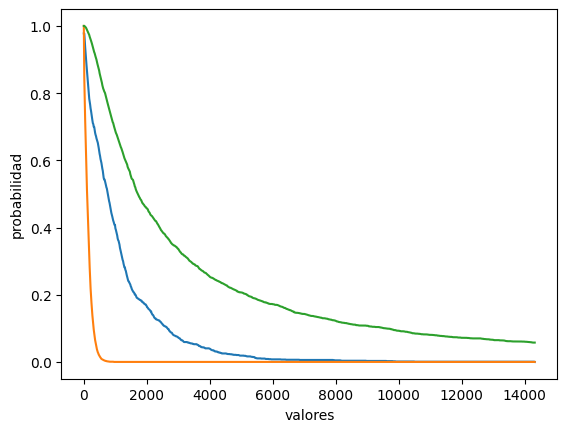

In [49]:
plt.plot(np.linspace(0,maxval,particiones),sf_obs_final,label="valores observados")
plt.plot(np.linspace(0,maxval,particiones),percentil025,label="percentil 2.5")
plt.plot(np.linspace(0,maxval,particiones),percentil975,label="percentil 97.5")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"kaplan meier.png")
plt.show()

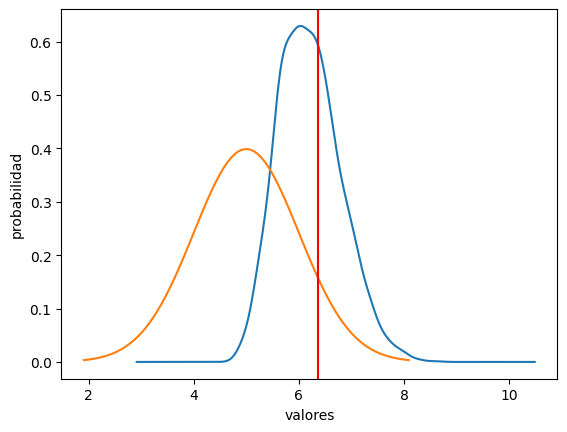

In [50]:
x_1 = np.linspace(stats.norm(5, 1).ppf(0.001),
                  stats.norm(5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_0 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_0 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta0.png")
plt.show()
contador+=1

In [51]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_0: "+str(q2)+", "+str(q3)+"\n\n"

5.194 7.467


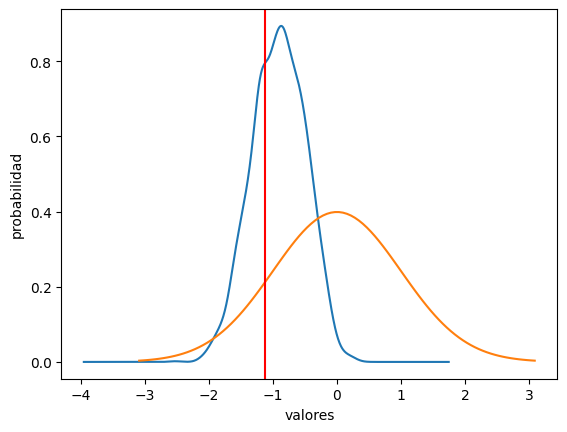

In [52]:
x_1 = np.linspace(stats.norm(0, 1).ppf(0.001),
                  stats.norm(0, 1).ppf(0.999), 100)
FDP_normal = stats.norm(0, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_1 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_1 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta1.png")
plt.show()
contador+=1

In [53]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_1: "+str(q2)+", "+str(q3)+"\n\n"

-1.73 -0.158


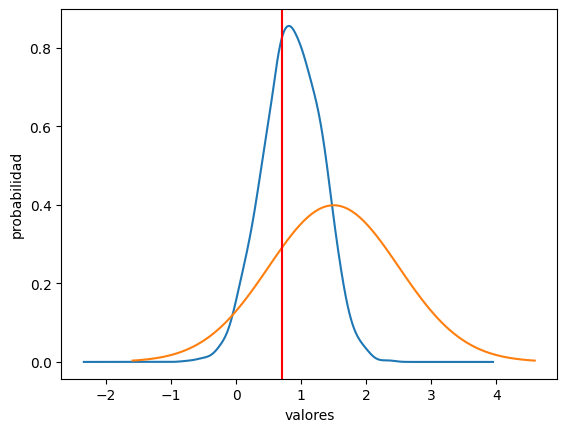

In [54]:
x_1 = np.linspace(stats.norm(1.5, 1).ppf(0.001),
                  stats.norm(1.5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_2 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_2 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta2.png")
plt.show()
contador+=1

In [55]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_2: "+str(q2)+", "+str(q3)+"\n\n"

-0.001 1.697


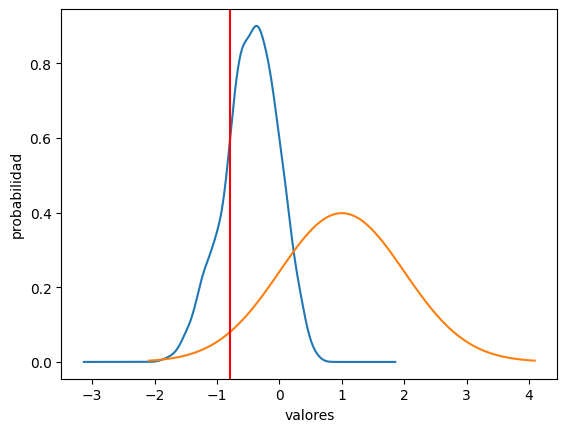

In [56]:
x_1 = np.linspace(stats.norm(1, 1).ppf(0.001),
                  stats.norm(1, 1).ppf(0.999), 100)
FDP_normal = stats.norm(1, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_3 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_3 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta3.png")
plt.show()
contador+=1

In [57]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_3: "+str(q2)+", "+str(q3)+"\n\n"

-1.352 0.316


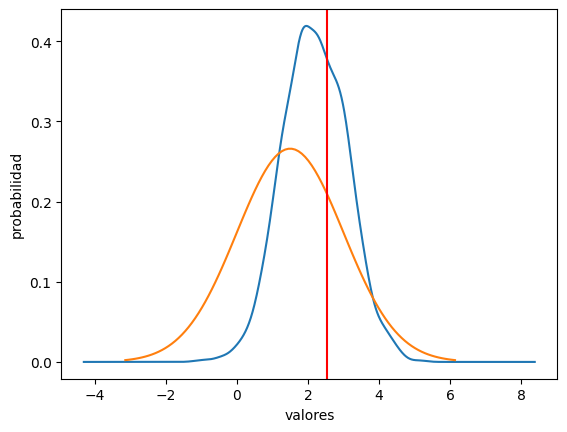

In [58]:
# Graficando Función de Densidad de Probibilidad con Python

x_1 = np.linspace(stats.norm(1.5, 1.5).ppf(0.001),
                  stats.norm(1.5, 1.5).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1.5).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_4 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_4 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta4.png")
plt.show()
contador+=1

In [59]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta4: "+str(q2)+", "+str(q3)+"\n\n"

0.493 3.964


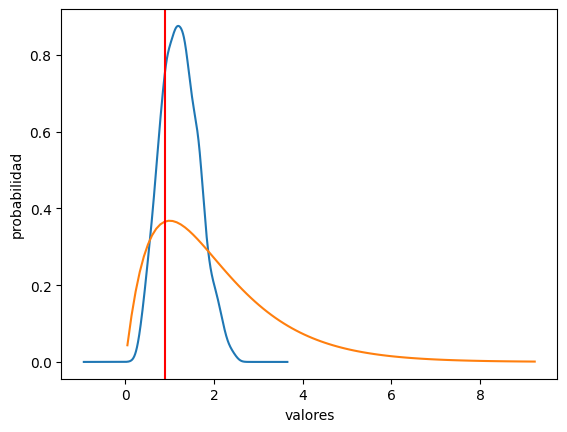

In [60]:
x_1 = np.linspace(stats.gamma(a=2,loc=0, scale=1).ppf(0.001),
                  stats.gamma(a=2,loc=0, scale=1).ppf(0.999), 100)
FDP_normal = stats.gamma(a=2,loc=0, scale=1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"gamma simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="gamma simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"gamma.png")
plt.show()

In [61]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="gamma: "+str(q2)+", "+str(q3)+"\n\n"

0.476 2.109


In [62]:
#aquí hago el archivo de texto con los intervalos de credibilidad
archivoic=open(nombre_carpeta+"/"+"intervalos_de_credibilidad.txt","w")
archivoic.write(ic)
archivoic.close()

In [63]:
###### aqui voy a hacer el csv

In [64]:
jalo=pd.DataFrame(data=tablas_km_buenas)
timelines=[]
for i in range(len(tablas_km)):
    timelines.append(tablas_km[i].index.max())
jalo["beta0"]=paramspost1[0]
jalo["beta1"]=paramspost1[1]
jalo["beta2"]=paramspost1[2]
jalo["beta3"]=paramspost1[3]
jalo["beta4"]=paramspost1[2]
jalo["gamma"]=paramspost1[4]
jalo["timeline"]=timelines

jalu=pd.DataFrame(data={"percentil025":percentil025,"percentil975":percentil975})

jalo.to_csv(nombre_carpeta+"/"+"datos_simulados_y_aceptados.csv")
jala=pd.DataFrame(sf_obs_final)
jala.to_csv(nombre_carpeta+"/"+"datos_km_observados_evaluados.csv")
jale=pd.DataFrame(sf_obs)
jale.to_csv(nombre_carpeta+"/"+"datos_km_observados.csv")
jalu.to_csv(nombre_carpeta+"/"+"percentiles.csv")

In [65]:
###################  beta2=0

In [66]:
#Uso este bloque para reiniciar las covariables a utilizar para cuando tenga que sacar una y después la necesite de vuelta
covariables_a_utilizar=['kW_del-5', 'kW_del max/prom', 'kW_del x_f-x_i', 'kVAr_del max-min']

In [67]:
#prueba con datos reales
Y=duracionesvida
X=[iniciostv["1"]]
covariables_a_utilizar.remove('kW_del max/prom')
for i in covariables_a_utilizar:
    if i != "kW_del max/prom":
        X.append(iniciostv[i]/10000)
    else:
        X.append(iniciostv[i])


XX=np.array(list(map(np.array,X)))
XX=XX.reshape(len(X),ndatos)

obsval=regresionlineal(list(XX),Y,0,1,False)

particiones=1000
kmf = KaplanMeierFitter()
kmf.fit(Y, np.ones(len(iniciostv)))
sf_obs=kmf.survival_function_
maxval=sf_obs.index.max()

In [68]:
obsval

[6.6444758456041,
 -0.8089539659878529,
 -0.9278382183442061,
 2.265074468329804,
 0.9034544671587779]

In [69]:
#función que uso para calibrar el modelo
def calibra(n=1):
    ndatos=1707
    #datos que usaré
    datobs=XX
    
    #simulo las prioris
    b0=np.random.RandomState().normal(loc=5,scale=1)
    b1=np.random.RandomState().normal(loc=0,scale=1)
    #b2=np.random.RandomState().normal(loc=1.5,scale=1)
    b3=np.random.RandomState().normal(loc=1,scale=1)
    b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
    gamma=np.random.RandomState().gamma(shape=2, scale=1)
    
    #simulo los datos
    sim=[]
    for i in range(ndatos):
        escala=b0*datobs[0][i]+b1*datobs[1][i]+b3*datobs[2][i]+b4*datobs[3][i]
        a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
        sim.append(a)
    sim=np.array(sim)

    #calculo los estadísticos descriptivos
    valores=regresionlineal(list(datobs),sim,0,1,from0=False)
    return valores

In [70]:
#cantidad de muestras que se usan para calibrar el modelo
muestras=32*312
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio1=time.time()
#acá guardo los resultados de la calibración
listaestats=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(calibra,range(muestras)):
        listaestats.append(resultado)
final1=time.time()
print("la calibración se demoró",final1-inicio1,"segundos")
#arreglo los datos para poder procesarlos después
listaestats=np.array(listaestats).T

la calibración se demoró 92.56571674346924 segundos


In [71]:
#acá proceso los datos para calcular el cuantil 1% de las diferencias entre los estadísticos simulados y los observados
desviaciones=[]
for i in range(len(listaestats)):
    desviaciones.append(listaestats[i].std())

cuads=[]
for i in range(len(desviaciones)): 
    cuads.append( np.power((obsval[i] - listaestats[i])/desviaciones[i],2) )

cuads=np.array(cuads)

newcarla=sum(cuads) 
newcarla=np.sqrt(newcarla)

df=pd.DataFrame(data=newcarla)  
q1=df.quantile(0.01)[0]
print("q1:",q1)

q1: 1.2918523576709064


In [72]:
#función donde se ejecuta la aceptación rechazo de las simulaciones
def aceptacionrechazo(n=1):
    ndatos=1707
    datobs=XX
    flag=True
    
    while flag:
        #simulo las prioris
        b0=np.random.RandomState().normal(loc=5,scale=1)
        b1=np.random.RandomState().normal(loc=0,scale=1)
        #b2=np.random.RandomState().normal(loc=1.5,scale=1)
        b3=np.random.RandomState().normal(loc=1,scale=1)
        b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
        gamma=np.random.RandomState().gamma(shape=2, scale=1)
        
        #simulo los datos
        sim=[]
        for i in range(ndatos):
            escala=b0*datobs[0][i]+b1*datobs[1][i]+b3*datobs[2][i]+b4*datobs[3][i]
            a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
            sim.append(a)
        sim=np.array(sim)
        
        #calculo los estadísticos descriptivos
        valores=regresionlineal(list(datobs),sim,0,1,from0=False)
        
        #calculo la distancia de los estadísticos descriptivos obtenidos a los simulados
        d=0
        for i in range(len(valores)):
            d+=np.power((obsval[i]-valores[i])/desviaciones[i],2)

        #si la distancia obtenida es menor que el cuantil 1 de las distancias entre estadisticos simulados y observados sigo
        if d<q1:
            sim2=sim#*np.exp( -np.dot(datobs.T,beta) )
            sim2=np.nan_to_num(sim2,posinf=0, neginf=0) 

            kmf = KaplanMeierFitter()
            kmf.fit(sim2,np.ones(len(sim2)))
            sf=kmf.survival_function_

            return ([b0,b1,b3,b4,gamma],sf)
            flag=False

In [73]:
#cantidad de muestras que el modelo va a aceptar
muestras2=32*78
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio2=time.time()
#acá guardo los resultados de la calibración
valores=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(aceptacionrechazo,range(muestras2)):
        valores.append(resultado)
final2=time.time()
print("la aceptacion rechazo se demoró",final2-inicio2,"segundos")

la aceptacion rechazo se demoró 5096.535141944885 segundos


In [74]:
#aquí proceso los datos para tener los resultados finales

#en este string guardaré los intervalos de credibilidad
ic=""

#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio3=time.time()

#separo los datos que entrega la aceptación rechazo para trabajarlos de forma independiente
paramspost1 = [j[0] for j in valores]
tablas_km = [j[1] for j in valores]

#arreglo los datos para poder procesarlos
paramspost1=np.array(paramspost1).T

#aquí guardaré los percentiles de los muestras aceptadas
percentil025=[]
percentil975=[]

#calculo Kaplan Meier de las muestras aceptadas
tablas_km_buenas=[]
for tabla in tablas_km:
    tablita=sacaindices(tabla,np.linspace(0,maxval,particiones))
    tablas_km_buenas.append(tablita)
tablas_km_buenas=np.array(tablas_km_buenas)

#calculo los percentiles de las muestras aceptadas
for tabla in tablas_km_buenas.T:
    p025=np.percentile(tabla,2.5)
    p975=np.percentile(tabla,97.5)
    percentil025.append(p025)
    percentil975.append(p975)
    
sf_obs_final=sacaindices(sf_obs,np.linspace(0,maxval,particiones))
final3=time.time()
print("el procesamiento se demoró",final3-inicio3,"segundos")

el procesamiento se demoró 228.023864030838 segundos


In [75]:
#este bloque es para automatizar la entrega de resultados
contador=0
nombre_carpeta="sin_beta2"
os.mkdir(nombre_carpeta)

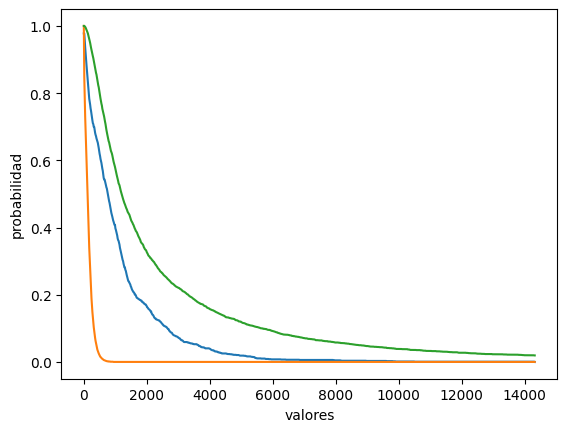

In [76]:
plt.plot(np.linspace(0,maxval,particiones),sf_obs_final,label="valores observados")
plt.plot(np.linspace(0,maxval,particiones),percentil025,label="percentil 2.5")
plt.plot(np.linspace(0,maxval,particiones),percentil975,label="percentil 97.5")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"kaplan meier.png")
plt.show()

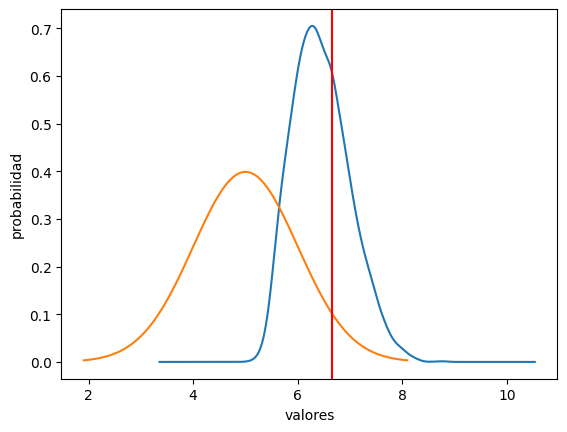

In [77]:
x_1 = np.linspace(stats.norm(5, 1).ppf(0.001),
                  stats.norm(5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_0 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_0 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta0.png")
plt.show()
contador+=1

In [78]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_0: "+str(q2)+", "+str(q3)+"\n\n"

5.564 7.618


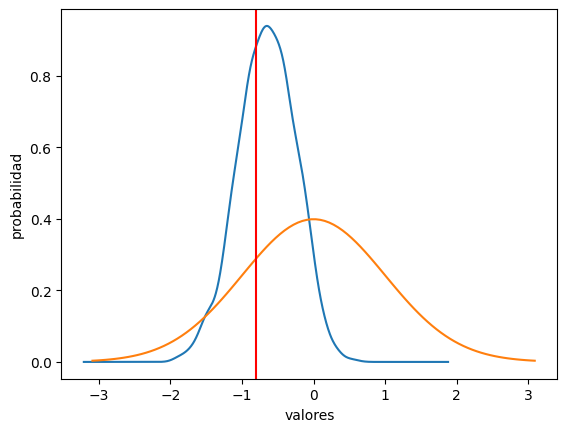

In [79]:
x_1 = np.linspace(stats.norm(0, 1).ppf(0.001),
                  stats.norm(0, 1).ppf(0.999), 100)
FDP_normal = stats.norm(0, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_1 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_1 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta1.png")
plt.show()
contador+=1

In [80]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_1: "+str(q2)+", "+str(q3)+"\n\n"

-1.485 0.081


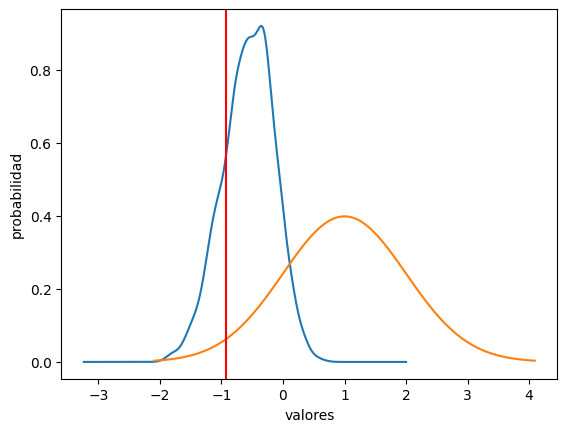

In [81]:
x_1 = np.linspace(stats.norm(1, 1).ppf(0.001),
                  stats.norm(1, 1).ppf(0.999), 100)
FDP_normal = stats.norm(1, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_3 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_3 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta3.png")
plt.show()
contador+=1

In [82]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_3: "+str(q2)+", "+str(q3)+"\n\n"

-1.44 0.194


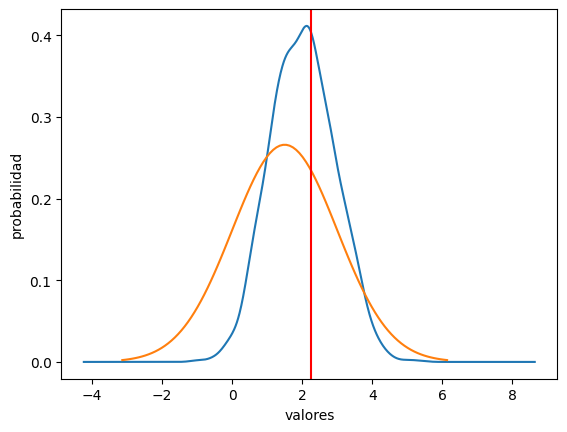

In [83]:
x_1 = np.linspace(stats.norm(1.5, 1.5).ppf(0.001),
                  stats.norm(1.5, 1.5).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1.5).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_4 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_4 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta4.png")
plt.show()
contador+=1

In [84]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta4: "+str(q2)+", "+str(q3)+"\n\n"

0.34 3.788


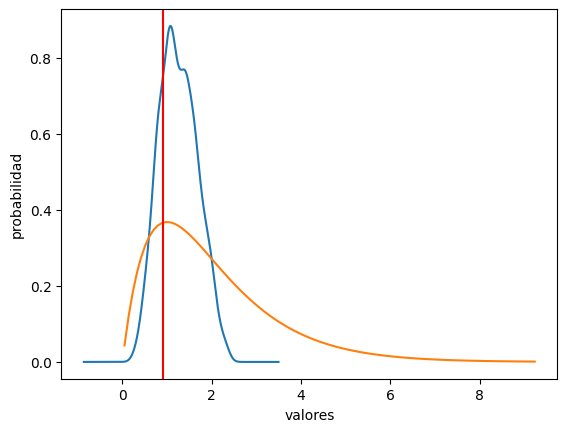

In [85]:
x_1 = np.linspace(stats.gamma(a=2,loc=0, scale=1).ppf(0.001),
                  stats.gamma(a=2,loc=0, scale=1).ppf(0.999), 100)
FDP_normal = stats.gamma(a=2,loc=0, scale=1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"gamma simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="gamma simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"gamma.png")
plt.show()

In [86]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="gamma: "+str(q2)+", "+str(q3)+"\n\n"

0.501 2.09


In [87]:
#aquí hago el archivo de texto con los intervalos de credibilidad
archivoic=open(nombre_carpeta+"/"+"intervalos_de_credibilidad.txt","w")
archivoic.write(ic)
archivoic.close()

In [88]:
###### aqui voy a hacer el csv

jalo=pd.DataFrame(data=tablas_km_buenas)
timelines=[]
for i in range(len(tablas_km)):
    timelines.append(tablas_km[i].index.max())
jalo["beta0"]=paramspost1[0]
jalo["beta1"]=paramspost1[1]
jalo["beta3"]=paramspost1[2]
jalo["beta4"]=paramspost1[3]
jalo["gamma"]=paramspost1[4]
jalo["timeline"]=timelines

jalu=pd.DataFrame(data={"percentil025":percentil025,"percentil975":percentil975})

jalo.to_csv(nombre_carpeta+"/"+"datos_simulados_y_aceptados.csv")
jala=pd.DataFrame(sf_obs_final)
jala.to_csv(nombre_carpeta+"/"+"datos_km_observados_evaluados.csv")
jale=pd.DataFrame(sf_obs)
jale.to_csv(nombre_carpeta+"/"+"datos_km_observados.csv")
jalu.to_csv(nombre_carpeta+"/"+"percentiles.csv")

In [89]:
##############################  beta3=0

In [90]:
#Uso este bloque para reiniciar las covariables a utilizar para cuando tenga que sacar una y después la necesite de vuelta
covariables_a_utilizar=['kW_del-5', 'kW_del max/prom', 'kW_del x_f-x_i', 'kVAr_del max-min']

In [91]:
#prueba con datos reales
Y=duracionesvida
X=[iniciostv["1"]]
covariables_a_utilizar.remove('kW_del x_f-x_i')
for i in covariables_a_utilizar:
    if i != "kW_del max/prom":
        X.append(iniciostv[i]/10000)
    else:
        X.append(iniciostv[i])

XX=np.array(list(map(np.array,X)))
XX=XX.reshape(len(X),ndatos)

obsval=regresionlineal(list(XX),Y,0,1,False)

particiones=1000
kmf = KaplanMeierFitter()
kmf.fit(Y, np.ones(len(iniciostv)))
sf_obs=kmf.survival_function_
maxval=sf_obs.index.max()

In [92]:
obsval

[6.358197581580156,
 -1.3553537127938808,
 0.9070564237125444,
 2.757270460344064,
 0.8988425049279465]

In [93]:
#función que uso para calibrar el modelo
def calibra(n=1):
    ndatos=1707
    #datos que usaré
    datobs=XX
    
    #simulo las prioris
    b0=np.random.RandomState().normal(loc=5,scale=1)
    b1=np.random.RandomState().normal(loc=0,scale=1)
    b2=np.random.RandomState().normal(loc=1.5,scale=1)
    #b3=np.random.RandomState().normal(loc=1,scale=1)
    b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
    gamma=np.random.RandomState().gamma(shape=2, scale=1)
    
    #simulo los datos
    sim=[]
    for i in range(ndatos):
        escala=b0*datobs[0][i]+b1*datobs[1][i]+b2*datobs[2][i]+b4*datobs[3][i]
        a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
        sim.append(a)
    sim=np.array(sim)

    #calculo los estadísticos descriptivos
    valores=regresionlineal(list(datobs),sim,0,1,from0=False)
    return valores

In [94]:
#cantidad de muestras que se usan para calibrar el modelo
muestras=32*312
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio1=time.time()
#acá guardo los resultados de la calibración
listaestats=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(calibra,range(muestras)):
        listaestats.append(resultado)
final1=time.time()
print("la calibración se demoró",final1-inicio1,"segundos")
#arreglo los datos para poder procesarlos después
listaestats=np.array(listaestats).T

la calibración se demoró 93.39799237251282 segundos


In [95]:
#acá proceso los datos para calcular el cuantil 1% de las diferencias entre los estadísticos simulados y los observados
desviaciones=[]
for i in range(len(listaestats)):
    desviaciones.append(listaestats[i].std())

cuads=[]
for i in range(len(desviaciones)): 
    cuads.append( np.power((obsval[i] - listaestats[i])/desviaciones[i],2) )

cuads=np.array(cuads)

newcarla=sum(cuads) 
newcarla=np.sqrt(newcarla)

df=pd.DataFrame(data=newcarla)  
q1=df.quantile(0.01)[0]
print("q1:",q1)

q1: 1.0498248326386674


In [96]:
#función donde se ejecuta la aceptación rechazo de las simulaciones
def aceptacionrechazo(n=1):
    ndatos=1707
    datobs=XX
    flag=True
    
    while flag:
        #simulo las prioris
        b0=np.random.RandomState().normal(loc=5,scale=1)
        b1=np.random.RandomState().normal(loc=0,scale=1)
        b2=np.random.RandomState().normal(loc=1.5,scale=1)
        #b3=np.random.RandomState().normal(loc=1,scale=1)
        b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
        gamma=np.random.RandomState().gamma(shape=2, scale=1)
        
        #simulo los datos
        sim=[]
        for i in range(ndatos):
            escala=b0*datobs[0][i]+b1*datobs[1][i]+b2*datobs[2][i]+b4*datobs[3][i]
            a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
            sim.append(a)
        sim=np.array(sim)
        
        #calculo los estadísticos descriptivos
        valores=regresionlineal(list(datobs),sim,0,1,from0=False)
        
        #calculo la distancia de los estadísticos descriptivos obtenidos a los simulados
        d=0
        for i in range(len(valores)):
            d+=np.power((obsval[i]-valores[i])/desviaciones[i],2)

        #si la distancia obtenida es menor que el cuantil 1 de las distancias entre estadisticos simulados y observados sigo
        if d<q1:
            sim2=sim#*np.exp( -np.dot(datobs.T,beta) )
            sim2=np.nan_to_num(sim2,posinf=0, neginf=0) 

            kmf = KaplanMeierFitter()
            kmf.fit(sim2,np.ones(len(sim2)))
            sf=kmf.survival_function_

            return ([b0,b1,b2,b4,gamma],sf)
            flag=False

In [97]:
#cantidad de muestras que el modelo va a aceptar
muestras2=32*78
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio2=time.time()
#acá guardo los resultados de la calibración
valores=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(aceptacionrechazo,range(muestras2)):
        valores.append(resultado)
final2=time.time()
print("la aceptacion rechazo se demoró",final2-inicio2,"segundos")

la aceptacion rechazo se demoró 2428.7182128429413 segundos


In [98]:
#aquí proceso los datos para tener los resultados finales

#en este string guardaré los intervalos de credibilidad
ic=""

#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio3=time.time()

#separo los datos que entrega la aceptación rechazo para trabajarlos de forma independiente
paramspost1 = [j[0] for j in valores]
tablas_km = [j[1] for j in valores]

#arreglo los datos para poder procesarlos
paramspost1=np.array(paramspost1).T

#aquí guardaré los percentiles de los muestras aceptadas
percentil025=[]
percentil975=[]

#calculo Kaplan Meier de las muestras aceptadas
tablas_km_buenas=[]
for tabla in tablas_km:
    tablita=sacaindices(tabla,np.linspace(0,maxval,particiones))
    tablas_km_buenas.append(tablita)
tablas_km_buenas=np.array(tablas_km_buenas)

#calculo los percentiles de las muestras aceptadas
for tabla in tablas_km_buenas.T:
    p025=np.percentile(tabla,2.5)
    p975=np.percentile(tabla,97.5)
    percentil025.append(p025)
    percentil975.append(p975)
    
sf_obs_final=sacaindices(sf_obs,np.linspace(0,maxval,particiones))
final3=time.time()
print("el procesamiento se demoró",final3-inicio3,"segundos")

el procesamiento se demoró 228.63427066802979 segundos


In [99]:
#este bloque es para automatizar la entrega de resultados
contador=0
nombre_carpeta="sin_beta3"
os.mkdir(nombre_carpeta)

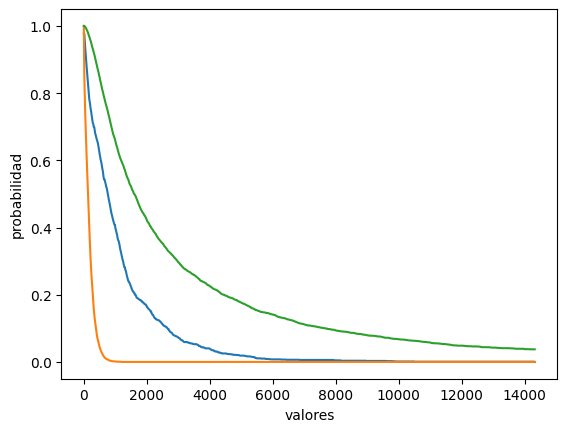

In [100]:
plt.plot(np.linspace(0,maxval,particiones),sf_obs_final,label="valores observados")
plt.plot(np.linspace(0,maxval,particiones),percentil025,label="percentil 2.5")
plt.plot(np.linspace(0,maxval,particiones),percentil975,label="percentil 97.5")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"kaplan meier.png")
plt.show()

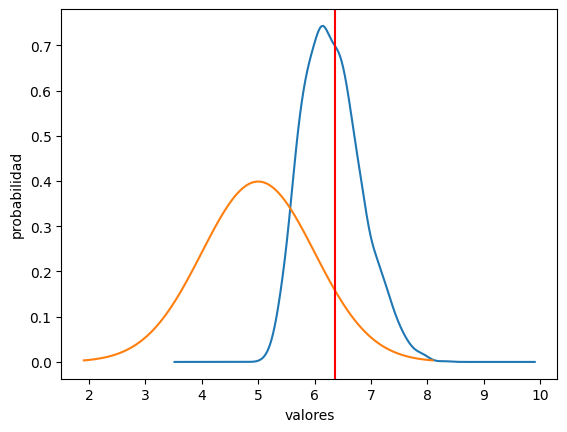

In [101]:
x_1 = np.linspace(stats.norm(5, 1).ppf(0.001),
                  stats.norm(5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_0 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_0 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta0.png")
plt.show()
contador+=1

In [102]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_0: "+str(q2)+", "+str(q3)+"\n\n"

5.446 7.423


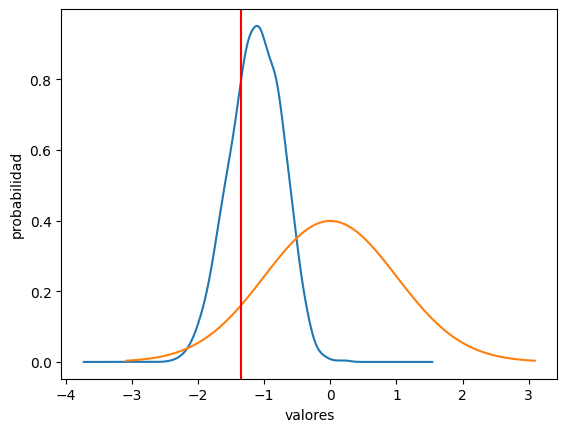

In [103]:
x_1 = np.linspace(stats.norm(0, 1).ppf(0.001),
                  stats.norm(0, 1).ppf(0.999), 100)
FDP_normal = stats.norm(0, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_1 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_1 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta1.png")
plt.show()
contador+=1

In [104]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_1: "+str(q2)+", "+str(q3)+"\n\n"

-1.92 -0.41


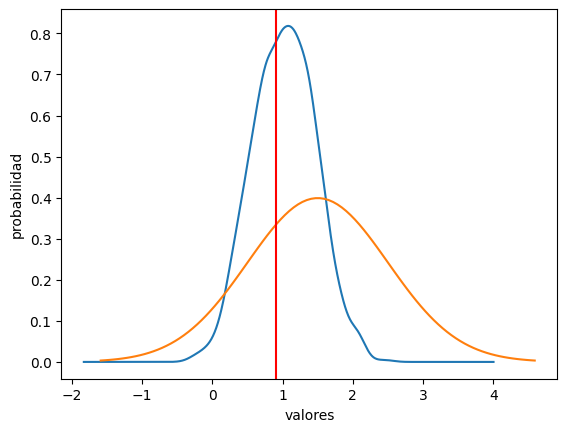

In [105]:
x_1 = np.linspace(stats.norm(1.5, 1).ppf(0.001),
                  stats.norm(1.5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_2 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_2 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta2.png")
plt.show()
contador+=1

In [106]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_2: "+str(q2)+", "+str(q3)+"\n\n"

0.189 1.893


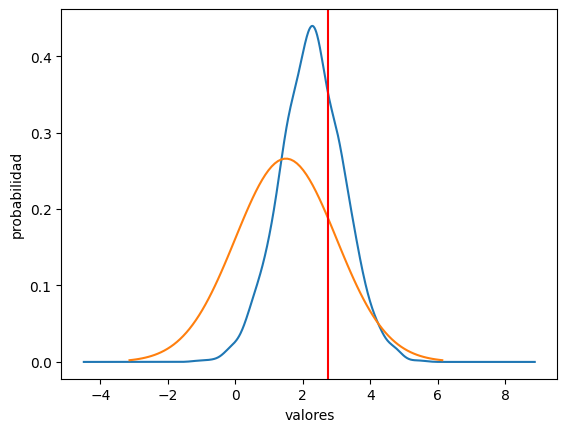

In [107]:
x_1 = np.linspace(stats.norm(1.5, 1.5).ppf(0.001),
                  stats.norm(1.5, 1.5).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1.5).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_4 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_4 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta4.png")
plt.show()
contador+=1

In [108]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta4: "+str(q2)+", "+str(q3)+"\n\n"

0.409 4.152


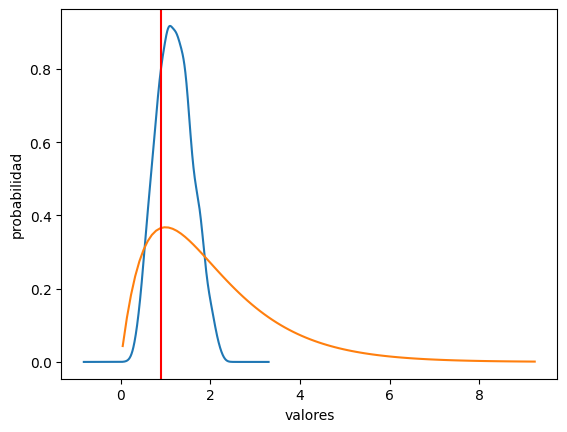

In [109]:
x_1 = np.linspace(stats.gamma(a=2,loc=0, scale=1).ppf(0.001),
                  stats.gamma(a=2,loc=0, scale=1).ppf(0.999), 100)
FDP_normal = stats.gamma(a=2,loc=0, scale=1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"gamma simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="gamma simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"gamma.png")
plt.show()

In [110]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="gamma: "+str(q2)+", "+str(q3)+"\n\n"

0.499 1.986


In [111]:
#aquí hago el archivo de texto con los intervalos de credibilidad
archivoic=open(nombre_carpeta+"/"+"intervalos_de_credibilidad.txt","w")
archivoic.write(ic)
archivoic.close()

In [112]:
###### aqui voy a hacer el csv

jalo=pd.DataFrame(data=tablas_km_buenas)
timelines=[]
for i in range(len(tablas_km)):
    timelines.append(tablas_km[i].index.max())
jalo["beta0"]=paramspost1[0]
jalo["beta1"]=paramspost1[1]
jalo["beta2"]=paramspost1[2]
jalo["beta4"]=paramspost1[3]
jalo["gamma"]=paramspost1[4]
jalo["timeline"]=timelines

jalu=pd.DataFrame(data={"percentil025":percentil025,"percentil975":percentil975})

jalo.to_csv(nombre_carpeta+"/"+"datos_simulados_y_aceptados.csv")
jala=pd.DataFrame(sf_obs_final)
jala.to_csv(nombre_carpeta+"/"+"datos_km_observados_evaluados.csv")
jale=pd.DataFrame(sf_obs)
jale.to_csv(nombre_carpeta+"/"+"datos_km_observados.csv")
jalu.to_csv(nombre_carpeta+"/"+"percentiles.csv")

In [113]:
##########################  gamma=1

In [114]:
#Uso este bloque para reiniciar las covariables a utilizar para cuando tenga que sacar una y después la necesite de vuelta
covariables_a_utilizar=['kW_del-5', 'kW_del max/prom', 'kW_del x_f-x_i', 'kVAr_del max-min']

In [115]:
#prueba con datos reales
Y=duracionesvida
X=[iniciostv["1"]]
for i in covariables_a_utilizar:
    if i != "kW_del max/prom":
        X.append(iniciostv[i]/10000)
    else:
        X.append(iniciostv[i])

XX=np.array(list(map(np.array,X)))
XX=XX.reshape(len(X),ndatos)

obsval=regresionlineal(list(XX),Y,0,1,False)
obsval.remove(obsval[5])

particiones=1000
kmf = KaplanMeierFitter()
kmf.fit(Y, np.ones(len(iniciostv)))
sf_obs=kmf.survival_function_
maxval=sf_obs.index.max()

In [116]:
obsval

[6.354374140455029,
 -1.1315631350767303,
 0.6999253394680444,
 -0.7899168369937026,
 2.532426562898837]

In [117]:
#función que uso para calibrar el modelo
def calibra(n=1):
    ndatos=1707
    #datos que usaré
    datobs=XX
    
    #simulo las prioris
    b0=np.random.RandomState().normal(loc=5,scale=1)
    b1=np.random.RandomState().normal(loc=0,scale=1)
    b2=np.random.RandomState().normal(loc=1.5,scale=1)
    b3=np.random.RandomState().normal(loc=1,scale=1)
    b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
    gamma=1 #np.random.RandomState().gamma(shape=2, scale=1)
    
    #simulo los datos
    sim=[]
    for i in range(ndatos):
        escala=b0*datobs[0][i]+b1*datobs[1][i]+b2*datobs[2][i]+b3*datobs[3][i]+b4*datobs[4][i]
        a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
        sim.append(a)
    sim=np.array(sim)

    #calculo los estadísticos descriptivos
    valores=regresionlineal(list(datobs),sim,0,1,from0=False)
    valores.remove(valores[5])
    return valores

In [118]:
#cantidad de muestras que se usan para calibrar el modelo
muestras=32*312
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio1=time.time()
#acá guardo los resultados de la calibración
listaestats=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(calibra,range(muestras)):
        listaestats.append(resultado)
final1=time.time()
print("la calibración se demoró",final1-inicio1,"segundos")
#arreglo los datos para poder procesarlos después
listaestats=np.array(listaestats).T

la calibración se demoró 94.12152051925659 segundos


In [119]:
#acá proceso los datos para calcular el cuantil 1% de las diferencias entre los estadísticos simulados y los observados
desviaciones=[]
for i in range(len(listaestats)):
    desviaciones.append(listaestats[i].std())

cuads=[]
for i in range(len(desviaciones)): 
    cuads.append( np.power((obsval[i] - listaestats[i])/desviaciones[i],2) )

cuads=np.array(cuads)

newcarla=sum(cuads) 
newcarla=np.sqrt(newcarla)

df=pd.DataFrame(data=newcarla)  
q1=df.quantile(0.01)[0]
print("q1:",q1)

q1: 1.5747574468474321


In [120]:
#función donde se ejecuta la aceptación rechazo de las simulaciones
def aceptacionrechazo(n=1):
    ndatos=1707
    datobs=XX
    flag=True
    
    while flag:
        #simulo las prioris
        b0=np.random.RandomState().normal(loc=5,scale=1)
        b1=np.random.RandomState().normal(loc=0,scale=1)
        b2=np.random.RandomState().normal(loc=1.5,scale=1)
        b3=np.random.RandomState().normal(loc=1,scale=1)
        b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
        gamma=1 #np.random.RandomState().gamma(shape=2, scale=1)
        
        #simulo los datos
        sim=[]
        for i in range(ndatos):
            escala=b0*datobs[0][i]+b1*datobs[1][i]+b2*datobs[2][i]+b3*datobs[3][i]+b4*datobs[4][i]
            a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
            sim.append(a)
        sim=np.array(sim)
        
        #calculo los estadísticos descriptivos
        valores=regresionlineal(list(datobs),sim,0,1,from0=False)
        valores.remove(valores[5])
        
        #calculo la distancia de los estadísticos descriptivos obtenidos a los simulados
        d=0
        for i in range(len(valores)):
            d+=np.power((obsval[i]-valores[i])/desviaciones[i],2)

        #si la distancia obtenida es menor que el cuantil 1 de las distancias entre estadisticos simulados y observados sigo
        if d<q1:
            sim2=sim#*np.exp( -np.dot(datobs.T,beta) )
            sim2=np.nan_to_num(sim2,posinf=0, neginf=0) 

            kmf = KaplanMeierFitter()
            kmf.fit(sim2,np.ones(len(sim2)))
            sf=kmf.survival_function_

            return ([b0,b1,b2,b3,b4],sf)
            flag=False

In [121]:
#cantidad de muestras que el modelo va a aceptar
muestras2=32*78
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio2=time.time()
#acá guardo los resultados de la calibración
valores=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(aceptacionrechazo,range(muestras2)):
        valores.append(resultado)
final2=time.time()
print("la aceptacion rechazo se demoró",final2-inicio2,"segundos")

la aceptacion rechazo se demoró 9192.546776533127 segundos


In [122]:
#aquí proceso los datos para tener los resultados finales

#en este string guardaré los intervalos de credibilidad
ic=""

#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio3=time.time()

#separo los datos que entrega la aceptación rechazo para trabajarlos de forma independiente
paramspost1 = [j[0] for j in valores]
tablas_km = [j[1] for j in valores]

#arreglo los datos para poder procesarlos
paramspost1=np.array(paramspost1).T

#aquí guardaré los percentiles de los muestras aceptadas
percentil025=[]
percentil975=[]

#calculo Kaplan Meier de las muestras aceptadas
tablas_km_buenas=[]
for tabla in tablas_km:
    tablita=sacaindices(tabla,np.linspace(0,maxval,particiones))
    tablas_km_buenas.append(tablita)
tablas_km_buenas=np.array(tablas_km_buenas)

#calculo los percentiles de las muestras aceptadas
for tabla in tablas_km_buenas.T:
    p025=np.percentile(tabla,2.5)
    p975=np.percentile(tabla,97.5)
    percentil025.append(p025)
    percentil975.append(p975)
    
sf_obs_final=sacaindices(sf_obs,np.linspace(0,maxval,particiones))
final3=time.time()
print("el procesamiento se demoró",final3-inicio3,"segundos")

el procesamiento se demoró 227.8534233570099 segundos


In [123]:
#este bloque es para automatizar la entrega de resultados
contador=0
nombre_carpeta="gamma=1"
os.mkdir(nombre_carpeta)

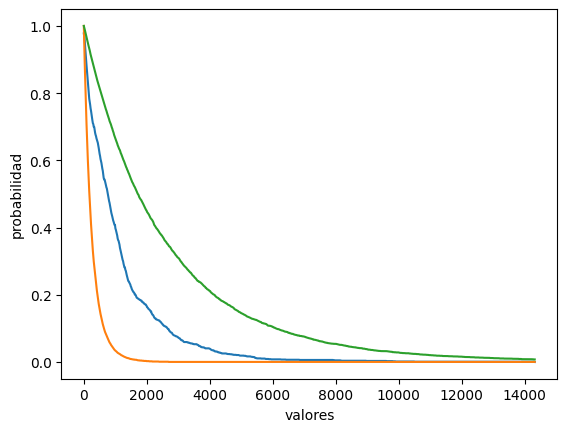

In [124]:
plt.plot(np.linspace(0,maxval,particiones),sf_obs_final,label="valores observados")
plt.plot(np.linspace(0,maxval,particiones),percentil025,label="percentil 2.5")
plt.plot(np.linspace(0,maxval,particiones),percentil975,label="percentil 97.5")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"kaplan meier.png")
plt.show()

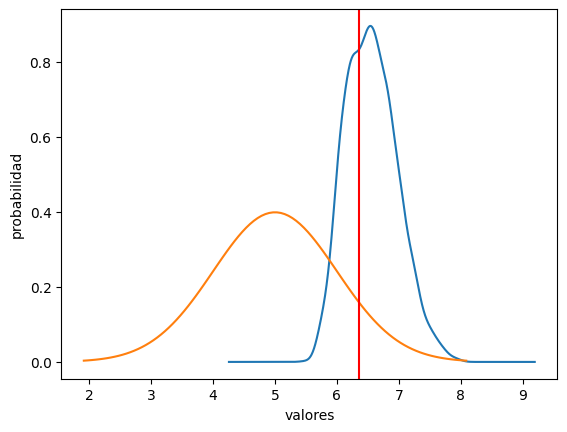

In [125]:
x_1 = np.linspace(stats.norm(5, 1).ppf(0.001),
                  stats.norm(5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_0 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_0 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta0.png")
plt.show()
contador+=1

In [126]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_0: "+str(q2)+", "+str(q3)+"\n\n"

5.864 7.438


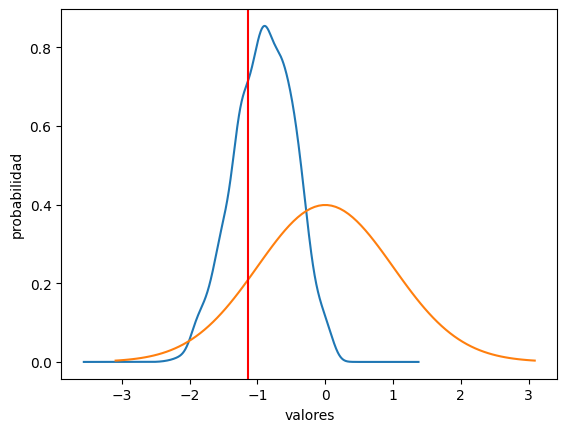

In [127]:
x_1 = np.linspace(stats.norm(0, 1).ppf(0.001),
                  stats.norm(0, 1).ppf(0.999), 100)
FDP_normal = stats.norm(0, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_1 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_1 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta1.png")
plt.show()
contador+=1

In [128]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_1: "+str(q2)+", "+str(q3)+"\n\n"

-1.801 -0.099


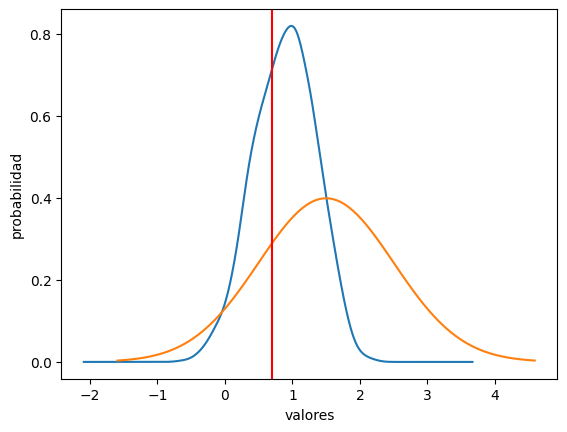

In [129]:
x_1 = np.linspace(stats.norm(1.5, 1).ppf(0.001),
                  stats.norm(1.5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_2 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_2 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta2.png")
plt.show()
contador+=1

In [130]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_2: "+str(q2)+", "+str(q3)+"\n\n"

-0.042 1.723


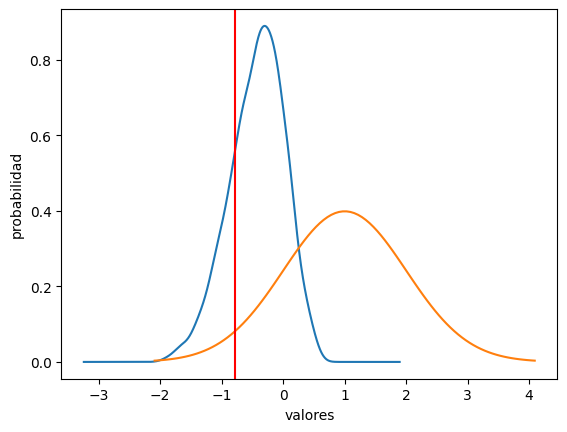

In [131]:
x_1 = np.linspace(stats.norm(1, 1).ppf(0.001),
                  stats.norm(1, 1).ppf(0.999), 100)
FDP_normal = stats.norm(1, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_3 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_3 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta3.png")
plt.show()
contador+=1

In [132]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_3: "+str(q2)+", "+str(q3)+"\n\n"

-1.387 0.343


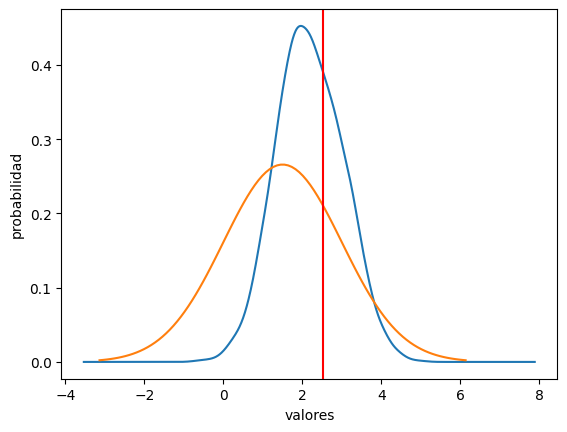

In [133]:
x_1 = np.linspace(stats.norm(1.5, 1.5).ppf(0.001),
                  stats.norm(1.5, 1.5).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1.5).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_4 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_4 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta4.png")
plt.show()
contador+=1

In [134]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta4: "+str(q2)+", "+str(q3)+"\n\n"

0.604 3.838


In [135]:
#aquí hago el archivo de texto con los intervalos de credibilidad
archivoic=open(nombre_carpeta+"/"+"intervalos_de_credibilidad.txt","w")
archivoic.write(ic)
archivoic.close()

In [136]:
###### aqui voy a hacer el csv

jalo=pd.DataFrame(data=tablas_km_buenas)
timelines=[]
for i in range(len(tablas_km)):
    timelines.append(tablas_km[i].index.max())
jalo["beta0"]=paramspost1[0]
jalo["beta1"]=paramspost1[1]
jalo["beta2"]=paramspost1[2]
jalo["beta3"]=paramspost1[3]
jalo["beta4"]=paramspost1[4]
jalo["timeline"]=timelines

jalu=pd.DataFrame(data={"percentil025":percentil025,"percentil975":percentil975})

jalo.to_csv(nombre_carpeta+"/"+"datos_simulados_y_aceptados.csv")
jala=pd.DataFrame(sf_obs_final)
jala.to_csv(nombre_carpeta+"/"+"datos_km_observados_evaluados.csv")
jale=pd.DataFrame(sf_obs)
jale.to_csv(nombre_carpeta+"/"+"datos_km_observados.csv")
jalu.to_csv(nombre_carpeta+"/"+"percentiles.csv")

In [143]:
############################ beta2=0, beta3=0 y gamma=1

In [144]:
#Uso este bloque para reiniciar las covariables a utilizar para cuando tenga que sacar una y después la necesite de vuelta
covariables_a_utilizar=['kW_del-5', 'kW_del max/prom', 'kW_del x_f-x_i', 'kVAr_del max-min']

In [145]:
#prueba con datos reales
Y=duracionesvida
X=[iniciostv["1"]]
covariables_a_utilizar.remove('kW_del max/prom')
covariables_a_utilizar.remove('kW_del x_f-x_i')
for i in covariables_a_utilizar:
    if i != "kW_del max/prom":
        X.append(iniciostv[i]/10000)
    else:
        X.append(iniciostv[i])


XX=np.array(list(map(np.array,X)))
XX=XX.reshape(len(X),ndatos)

obsval=regresionlineal(list(XX),Y,0,1,False)
obsval.remove(obsval[3])

particiones=1000
kmf = KaplanMeierFitter()
kmf.fit(Y, np.ones(len(iniciostv)))
sf_obs=kmf.survival_function_
maxval=sf_obs.index.max()

In [146]:
obsval

[6.755546393933563, -0.9678911463785219, 2.445570401128637]

In [147]:
#función que uso para calibrar el modelo
def calibra(n=1):
    ndatos=1707
    #datos que usaré
    datobs=XX
    
    #simulo las prioris
    b0=np.random.RandomState().normal(loc=5,scale=1)
    b1=np.random.RandomState().normal(loc=0,scale=1)
    #b2=np.random.RandomState().normal(loc=1.5,scale=1)
    #b3=np.random.RandomState().normal(loc=1,scale=1)
    b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
    gamma=1 #np.random.RandomState().gamma(shape=2, scale=1)
    
    #simulo los datos
    sim=[]
    for i in range(ndatos):
        escala=b0*datobs[0][i]+b1*datobs[1][i]+b4*datobs[2][i]
        a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
        sim.append(a)
    sim=np.array(sim)

    #calculo los estadísticos descriptivos
    valores=regresionlineal(list(datobs),sim,0,1,from0=False)
    valores.remove(valores[3])
    return valores

In [148]:
#cantidad de muestras que se usan para calibrar el modelo
muestras=32*312
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio1=time.time()
#acá guardo los resultados de la calibración
listaestats=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(calibra,range(muestras)):
        listaestats.append(resultado)
final1=time.time()
print("la calibración se demoró",final1-inicio1,"segundos")
#arreglo los datos para poder procesarlos después
listaestats=np.array(listaestats).T

la calibración se demoró 92.89077687263489 segundos


In [149]:
#acá proceso los datos para calcular el cuantil 1% de las diferencias entre los estadísticos simulados y los observados
desviaciones=[]
for i in range(len(listaestats)):
    desviaciones.append(listaestats[i].std())

cuads=[]
for i in range(len(desviaciones)): 
    cuads.append( np.power((obsval[i] - listaestats[i])/desviaciones[i],2) )

cuads=np.array(cuads)

newcarla=sum(cuads) 
newcarla=np.sqrt(newcarla)

df=pd.DataFrame(data=newcarla)  
q1=df.quantile(0.01)[0]
print("q1:",q1)

q1: 0.911012920801438


In [150]:
#función donde se ejecuta la aceptación rechazo de las simulaciones
def aceptacionrechazo(n=1):
    ndatos=1707
    datobs=XX
    flag=True
    
    while flag:
        #simulo las prioris
        b0=np.random.RandomState().normal(loc=5,scale=1)
        b1=np.random.RandomState().normal(loc=0,scale=1)
        #b2=np.random.RandomState().normal(loc=1.5,scale=1)
        #b3=np.random.RandomState().normal(loc=1,scale=1)
        b4=np.random.RandomState().normal(loc=1.5,scale=1.5)
        gamma=1 #np.random.RandomState().gamma(shape=2, scale=1)
        
        #simulo los datos
        sim=[]
        for i in range(ndatos):
            escala=b0*datobs[0][i]+b1*datobs[1][i]+b4*datobs[2][i]
            a=stats.weibull_min.rvs(c=gamma, scale=np.exp(escala))
            sim.append(a)
        sim=np.array(sim)
        
        #calculo los estadísticos descriptivos
        valores=regresionlineal(list(datobs),sim,0,1,from0=False)
        valores.remove(valores[3])
        
        #calculo la distancia de los estadísticos descriptivos obtenidos a los simulados
        d=0
        for i in range(len(valores)):
            d+=np.power((obsval[i]-valores[i])/desviaciones[i],2)

        #si la distancia obtenida es menor que el cuantil 1 de las distancias entre estadisticos simulados y observados sigo
        if d<q1:
            sim2=sim#*np.exp( -np.dot(datobs.T,beta) )
            sim2=np.nan_to_num(sim2,posinf=0, neginf=0) 

            kmf = KaplanMeierFitter()
            kmf.fit(sim2,np.ones(len(sim2)))
            sf=kmf.survival_function_

            return ([b0,b1,b4],sf)
            flag=False

In [151]:
#cantidad de muestras que el modelo va a aceptar
muestras2=32*78
#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio2=time.time()
#acá guardo los resultados de la calibración
valores=[]
#ejecuto la generación de datos para calibrar usando programación paralela
with concurrent.futures.ProcessPoolExecutor() as executor:
    for resultado in executor.map(aceptacionrechazo,range(muestras2)):
        valores.append(resultado)
final2=time.time()
print("la aceptacion rechazo se demoró",final2-inicio2,"segundos")

la aceptacion rechazo se demoró 2055.0780816078186 segundos


In [152]:
#aquí proceso los datos para tener los resultados finales

#en este string guardaré los intervalos de credibilidad
ic=""

#acá empiezo a medir el tiempo para ver cuanto demora este fragmento de código
inicio3=time.time()

#separo los datos que entrega la aceptación rechazo para trabajarlos de forma independiente
paramspost1 = [j[0] for j in valores]
tablas_km = [j[1] for j in valores]

#arreglo los datos para poder procesarlos
paramspost1=np.array(paramspost1).T

#aquí guardaré los percentiles de los muestras aceptadas
percentil025=[]
percentil975=[]

#calculo Kaplan Meier de las muestras aceptadas
tablas_km_buenas=[]
for tabla in tablas_km:
    tablita=sacaindices(tabla,np.linspace(0,maxval,particiones))
    tablas_km_buenas.append(tablita)
tablas_km_buenas=np.array(tablas_km_buenas)

#calculo los percentiles de las muestras aceptadas
for tabla in tablas_km_buenas.T:
    p025=np.percentile(tabla,2.5)
    p975=np.percentile(tabla,97.5)
    percentil025.append(p025)
    percentil975.append(p975)
    
sf_obs_final=sacaindices(sf_obs,np.linspace(0,maxval,particiones))
final3=time.time()
print("el procesamiento se demoró",final3-inicio3,"segundos")

el procesamiento se demoró 225.91941452026367 segundos


In [153]:
#este bloque es para automatizar la entrega de resultados
contador=0
nombre_carpeta="todo_eval"
os.mkdir(nombre_carpeta)

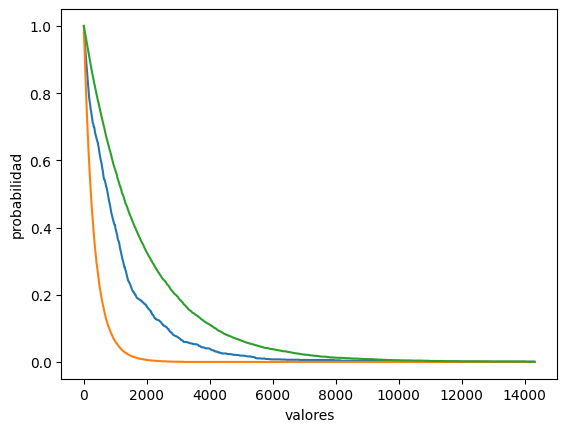

In [154]:
plt.plot(np.linspace(0,maxval,particiones),sf_obs_final,label="valores observados")
plt.plot(np.linspace(0,maxval,particiones),percentil025,label="percentil 2.5")
plt.plot(np.linspace(0,maxval,particiones),percentil975,label="percentil 97.5")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"kaplan meier.png")
plt.show()

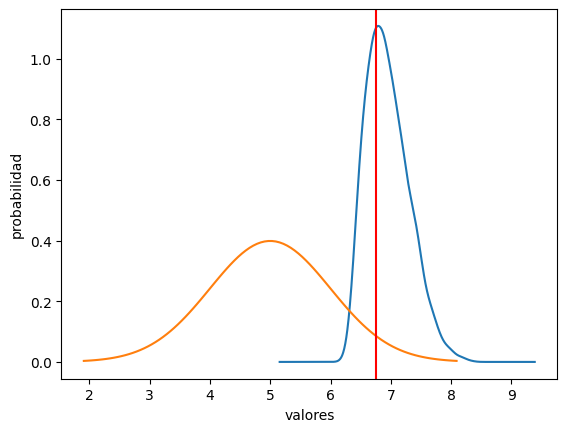

In [155]:
x_1 = np.linspace(stats.norm(5, 1).ppf(0.001),
                  stats.norm(5, 1).ppf(0.999), 100)
FDP_normal = stats.norm(5, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_0 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_0 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta0.png")
plt.show()
contador+=1

In [156]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_0: "+str(q2)+", "+str(q3)+"\n\n"

6.401 7.736


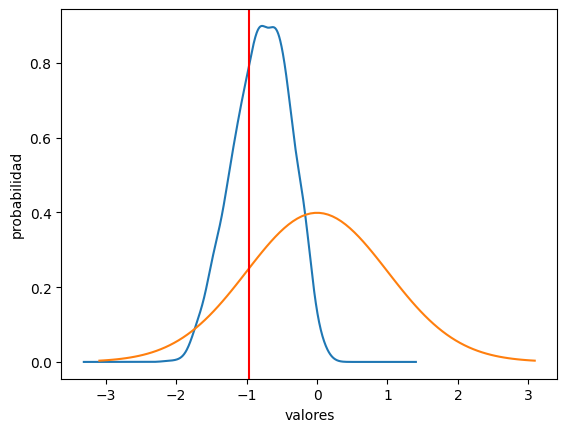

In [157]:
x_1 = np.linspace(stats.norm(0, 1).ppf(0.001),
                  stats.norm(0, 1).ppf(0.999), 100)
FDP_normal = stats.norm(0, 1).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_1 posteriori":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_1 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta1.png")
plt.show()
contador+=1

In [158]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta_1: "+str(q2)+", "+str(q3)+"\n\n"

-1.587 -0.098


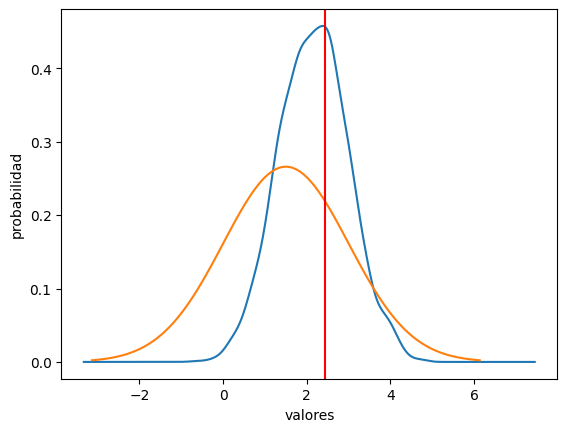

In [159]:
x_1 = np.linspace(stats.norm(1.5, 1.5).ppf(0.001),
                  stats.norm(1.5, 1.5).ppf(0.999), 100)
FDP_normal = stats.norm(1.5, 1.5).pdf(x_1) # FDP
tetasdf=pd.DataFrame(data={"beta_4 simulados":paramspost1[contador]})
tetasdf.plot(kind="density",legend=False)
#plt.hist(tetasdf,label="beta_4 simulados",density=True)
plt.plot(x_1, FDP_normal, label='distribución a priori')
plt.axvline(x=obsval[contador], ymin=0, ymax=1,label="valor observado",color="red")
plt.ylabel('probabilidad')
plt.xlabel('valores')
#plt.legend()
plt.savefig(nombre_carpeta+"/"+"beta4.png")
plt.show()
contador+=1

In [160]:
q2=round(tetasdf.quantile(0.025)[0],3)
q3=round(tetasdf.quantile(0.975)[0],3)
print(q2,q3)
ic+="beta4: "+str(q2)+", "+str(q3)+"\n\n"

0.573 3.823


In [161]:
#aquí hago el archivo de texto con los intervalos de credibilidad
archivoic=open(nombre_carpeta+"/"+"intervalos_de_credibilidad.txt","w")
archivoic.write(ic)
archivoic.close()

In [162]:
###### aqui voy a hacer el csv

jalo=pd.DataFrame(data=tablas_km_buenas)
timelines=[]
for i in range(len(tablas_km)):
    timelines.append(tablas_km[i].index.max())
jalo["beta0"]=paramspost1[0]
jalo["beta1"]=paramspost1[1]
jalo["beta4"]=paramspost1[2]
jalo["timeline"]=timelines

jalu=pd.DataFrame(data={"percentil025":percentil025,"percentil975":percentil975})

jalo.to_csv(nombre_carpeta+"/"+"datos_simulados_y_aceptados.csv")
jala=pd.DataFrame(sf_obs_final)
jala.to_csv(nombre_carpeta+"/"+"datos_km_observados_evaluados.csv")
jale=pd.DataFrame(sf_obs)
jale.to_csv(nombre_carpeta+"/"+"datos_km_observados.csv")
jalu.to_csv(nombre_carpeta+"/"+"percentiles.csv")